# BOTS Time Series Observations

**Use case:** Bright Object Time Series; extracting exoplanet spectra.<br>
**Data:** JWST simulated NIRSpec data from ground-based campaign; GJ436b spectra from the Goyal et al. (2018).<br>
**Tools:**  scikit, lmfit, scipy, matplotlip, astropy, pandas.<br>
**Cross-intrument:** . <br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>
**Author:** David K. Sing (dsing@jhu.edu)<br>
**Last updated:** 2 July 2020

## Introduction

This notebook uses time series JWST NIRSpec data taken during a ground-based campaign to illustrate extracting exoplanet spectra from time-series observations.  

The data are derived from the ISIM-CV3, the cryovacuum campaign of the JWST Integrated Science Instrument Module (ISIM), that took place at Goddard Space Flight Center during the winter 2015-2016 (Kimble et al. 2016). The data can be found at https://www.cosmos.esa.int/web/jwst-nirspec/test-data, and detailed and insightful report of the data by G. Giardino, S. Birkmann, P. Ferruit, B. Dorner, B. Rauscher can be found here: ftp://ftp.cosmos.esa.int/jwstlib/ReleasedCV3dataTimeSeries/CV3_TimeSeries_PRM.tgz

This NIRSpec time series dataset has had a transit light curve injected at the pixel-level, which closely mimics a bright object time series (BOTS) observation of a transiting exoplanet. In this case, a GJ436b spectra from the 
__[Goyal et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.5158G/)__ 
exoplanet grid was selected (clear atmosphere at solar metallicity).  With an actual NIRSpec dataset, the noise properties of the detector, jitter, and the effects on extracting exoplanet spectra from time-series observations can more accurately simulated.

Broadly the aim of this notebook is to work with these time series observations to:

 1) Extract 1D spectra from the 2D spectral images. 
    
 2) Define a time series model to fit to the wavelength dependent transit light curve.
    
 3) Fit each time series wavelength bin of the 1D spectra, measuring the desired quantity $R_{pl}(\lambda)/R_{star}$.
 
 4) Produce a measured transmission spectrum that can then be compared to models.
 
The example outputs the fit light curves for each spectral bin, along with fitting statistics.



## Load packages

This notebook uses packages (matplotlib, astropy, scipy, glob, lmfit, pickle, os, sklearn) which can all be installed in a standard fashion through pip.

Several routines to calculate limb-darkening and a transit model were extracted from ExoTiC-ISm 
(__[Laginja & Wakeford 2020](https://ui.adsabs.harvard.edu/abs/2020JOSS....5.2281L/)__ ;
https://github.com/hrwakeford/ExoTiC-ISM), and slightly adapted. The full set of stellar models used for the limb-darkening calculation can also be downloaded from ExoTiC-ISM, as this notebook only downloads and loads the single stellar model used to generate the limb darkening.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.backends.backend_pdf import PdfPages
from astropy.utils.data import get_pkg_data_filename, download_file
from astropy.table import Table, Column, MaskedColumn
from astropy.io import fits, ascii
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
import astropy.units as u
from scipy.interpolate import interp1d, splev, splrep
import scipy.optimize as opt
from scipy.io import readsav
from scipy import stats
import glob
import lmfit
import pickle
from os import path,mkdir
from sklearn.linear_model import LinearRegression
import warnings
import pandas as pd
import os
import shutil

## Setup Parameters

Parameters of the fit include directories where the data and limb darkening stellar models are held, along with properties of the planet and star. The stellar and planet values that have been entered here (modeled after GJ436) are the same as was used to model the injected transit.  Note, the 4500K stellar model used to inject the transit was hotter than GJ436A.

In [2]:
#---------------------------------------------------------
# SETUP  ----------------------------------------------
# Setup directories
save_directory      ='./notebookrun2/'          #local directory to save files to
data_directory      ='./'                       #local data to work with fits files if desired

# Setup Detector Properties & Rednoise measurement timescale 
gain               = 1.0  # 2D spectra has already converted to counts, gain of detector is 1.0
binmeasure         = 256  # Binning technique to measure rednoise, choose bin size to evaluate sigma_r
number_of_images   = 8192 # Number of images in the dataset

# Setup Planet Properies
grating    = 'NIRSpecPrism'
ld_model   = '3D'         # 3D/1D stellar model choise (transit was injected with the 3D model)

# Setup Stellar Properies for Limb-Darkening Calculation
Teff     = 4500           # Effective Temperature (K)
logg     = 4.5            # Surface Gravity
M_H      = 0.0            # Stellar Metallicity log_10[M/H]
Rstar    = 0.455          # planet radius (in units of solar radii Run)

#Setup Transit parameters (can get from Nasa exoplanet archive)
t0       = 2454865.084034              # bjd time of inferior conjunction 
per      = 2.64389803                  # orbital period (days) BJD_TDB
rp       = 0.0804                      # planet radius (in units of stellar radii)
a_Rs     = 14.54                       # semi-major axis (input a/Rstar so units of stellar radii)
inc      = 86.858  *(2*np.pi/360)      # orbital inclination (in degrees->radians)
ecc      = 0.0                         # eccentricity
omega    = 0.0  *(2*np.pi/360)         # longitude of periastron (in degrees->radians)

rho_star = (3*np.pi)/(6.67259E-8*(per*86400)**2)*(a_Rs)**3     # Stellar Density (g/cm^3) from a/Rs
# a_Rs=(rho_star*6.67259E-8*per_sec*per_sec/(3*np.pi))**(1/3)  # a/Rs from Stellar Density (g/cm^3)
#---------------------------------------------------------


In [3]:
# Create local directories
if path.exists(save_directory) == False: mkdir(save_directory)      #Create new directory to save outputs to if needed
if path.exists(save_directory+'3DGrid') == False: mkdir(save_directory+'3DGrid')      #Create new directory to save
limb_dark_directory = save_directory               # point to limb darkeing directory contaning 3DGrid/ directory

# Download and Load NIRSpec data

The fits images are loaded, and information including the image date and science spectra are saved.

A default flux offset value BZERO is also taken from the header and subtracted from every science frame.

Reading in the 2^13 fits files is slow.  To speed things up, we created a pickle file of the for first instance the fits images are loaded.  This 1GB pickle file is loaded instead of reading the fits files if found.

Alternatively, the fits files can be downloaded here:
https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/transit_spectroscopy_notebook/Archive.Trace_SLIT_A_1600_SRAD-PRM-PS-6007102143_37803_JLAB88_injected.tar.gz.  The images are in a tar.gz archvie, which needs to be un-archived and data_directory variable set to the directory in the SETUP cell above.

The cell below downloads the 1GB JWST data pickle file, and several other files needed.

In [4]:
#Download 1GB NIRSpec Data
fn_jw=save_directory+'jwst_data.pickle'
if path.exists(fn_jw) == False:
    fn   = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/transit_spectroscopy_notebook/jwst_data.pickle')
    dest = shutil.move(fn,save_directory+'jwst_data.pickle')  
    print('JWST Data Download Complete')

#Download further files needed, move to local directory for easier repeated access
fn_sens= download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/transit_spectroscopy_notebook/NIRSpec.prism.sensitivity.sav')
dest   = shutil.move(fn_sens,save_directory+'NIRSpec.prism.sensitivity.sav')  #Move files to save_directory

fn_ld  = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/transit_spectroscopy_notebook/3DGrid/mmu_t45g45m00v05.flx')
destld = shutil.move(fn_ld,save_directory+'3DGrid/mmu_t45g45m00v05.flx')        

JWST Data Download Complete


Loads the Pickle File data.  Alternatly, the data can be read from the original fits files.

In [5]:
if path.exists(fn_jw) == True:
    dbfile = open(fn_jw, 'rb') # for reading also binary mode is important
    jwst_data = pickle.load(dbfile)
    print('Loading JWST data from Pickle File')
    bjd            =jwst_data['bjd']
    wsdata_all     =jwst_data['wsdata_all']
    shx            =jwst_data['shx']
    shy            =jwst_data['shy']
    common_mode    =jwst_data['common_mode']
    all_spec       =jwst_data['all_spec']
    exposure_length=jwst_data['exposure_length']
    dbfile.close()    
    print('Done')
elif path.exists(fn_jw) == False:
    #---------------------------------------------------------
    # load all fits images
    # Arrays created for BJD time, and the white light curve total_counts
    list=glob.glob(data_directory+"*.fits")
    index_of_images=np.arange(number_of_images) #
    bjd=np.zeros((number_of_images))
    exposure_length=np.zeros((number_of_images))
    all_spec=np.zeros((32,512,number_of_images))
    for i in index_of_images:
        img=list[i]
        print(img)
        hdul=fits.open(img)
        #hdul.info()
        bjd_image=hdul[0].header['BJD_TDB']
        BZERO=hdul[0].header['BZERO']        #flux value offset
        bjd[i]=bjd_image
        expleng=hdul[0].header['INTTIME']    #Total integration time for one MULTIACCUM (seconds)
        exposure_length[i]=expleng/86400.    #Total integration time for one MULTIACCUM (days)
        print(bjd[i])
        data = hdul[0].data
        #total counts in image
        #total_counts[i]=gain*np.sum(data[11:18,170:200]-BZERO) #total counts in 12 pix wide aperature around pixel 60 image
        all_spec[:,:,i]=gain*(data-BZERO)     #load all spectra into an array subtract flux value offset
        hdul.close()
    #Sort data
    srt=np.argsort(bjd) #index to sort
    bjd=bjd[srt]
    #total_counts=total_counts[srt]
    exposure_length=exposure_length[srt]
    all_spec[:,:,:]=all_spec[:,:,srt]

    # Get Wavelegnth of Data
    file_wave = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/transit_spectroscopy_notebook/JWST_NIRSpec_wavelength_microns.txt')
    f = open(file_wave, 'r')
    wsdata_all = np.genfromtxt(f)
    
    print('wsdata size :',wsdata_all.shape)
    print('Data wavelength Loaded :',wsdata_all)
    print('wsdata new size :',wsdata_all.shape)
    
    #---------------------------------------------------------
    # Read in Detrending parameters
    # Mean of parameter must be 0.0 to be properly normalized
    # Idealy standard deviation of paramter = 1.0
    file_xy=download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/transit_spectroscopy_notebook/JWST_NIRSpec_Xposs_Yposs_CM_detrending.txt')
    f = open(file_xy, 'r')
    data = np.genfromtxt(f, delimiter=',')
    shx        = data[:,0]
    shy        = data[:,1]
    common_mode= data[:,2]
    
    #Store Data into a pickle file
    jwst_data={'bjd':bjd, 'wsdata_all':wsdata_all, 'shx':shx , 'shy':shy , 'common_mode':common_mode, 'all_spec':all_spec, 'exposure_length':exposure_length}
    dbfile = open('jwst_data.pickle', 'ab') # Its important to use binary mode
    pickle.dump(jwst_data,dbfile)
    dbfile.close()
    #---------------------------------------------------------

    

Loading JWST data from Pickle File
Done


# Visualizing the 2D spectral data

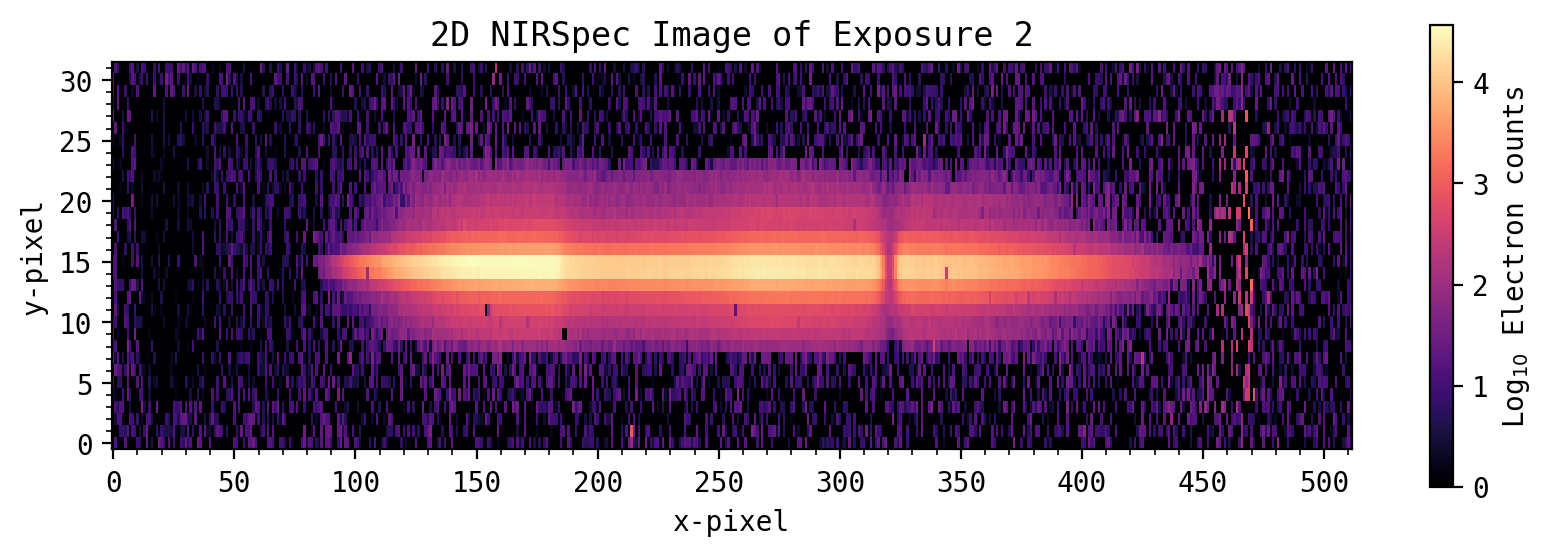

In [6]:
expnum=2                                           #Choose Exposure number to view

plt.rcParams['figure.figsize'] = [10.0, 3.0]           # Figure dimensions
plt.rcParams['figure.dpi']     = 200                   # Resolution
plt.rcParams['savefig.dpi']    = 200
plt.rcParams['image.aspect']   = 5                     # Aspect ratio (the CCD is quite long!!!)
plt.cmap = plt.cm.magma
plt.cmap.set_bad('k',1.)
plt.rcParams['image.cmap'] = 'magma'                   # Colormap.
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.family'] = "monospace"
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

img=all_spec[:,:,expnum]
zeros=np.where(img <= 0)     #Plot on a log scale, so set zero or negative values to a small number 
img[zeros]=1E-10
fig,axs = plt.subplots()
f=axs.imshow(np.log10(img),vmin=0) #Plot image
plt.xlabel('x-pixel')
plt.ylabel('y-pixel')
axs.yaxis.set_major_locator(ticker.MultipleLocator(5))
axs.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axs.xaxis.set_major_locator(ticker.MultipleLocator(50))
axs.xaxis.set_minor_locator(ticker.MultipleLocator(10))
plt.title('2D NIRSpec Image of Exposure '+str(expnum))
fig.colorbar(f,label='Log$_{10}$ Electron counts',ax=axs)
plt.show()


# Extract 1D spectra from 2D array of images

Ideally, extracting 1D spectra from the 2D images would use optimal aperture extraction along a fit 
trace with routines equivalent to IRAF/apall. This functionality is not yet available in astro-py.

Several processing steps have already been applied.  The 2D spectra here have been flat field corrected, and 1/f noise has been removed from each pixel by subtracting the median count rate from the un-illuminated pixels along each column (see __[Giardino et al.](ftp://ftp.cosmos.esa.int/jwstlib/ReleasedCV3dataTimeSeries/CV3_TimeSeries_PRM.tgz)__
for more information about 1/f noise).  Each 2D image has also been aligned in the X and Y directions, such that each pixel corresponds to the same wavelength.  As the CV3 test had no requirements for flux stability, the ~1% flux variations from the LED have also been removed.  
    
For spectral extraction, the example here simply uses a simple summed box.  The 8192 2D spectra have been
pre-loaded into a numpy array.  The spectra peaks at pixel Y=16. For each column, an aperature sum is taken over Y-axis pixels 11 to 18, which
contains most of the spectrum counts. Wider aperture would add more counts, but also introduces more noise.

**Further cleaning steps are not done here** 

1) Ideally, the pixels flagged as bad for various reasons should be cleaned.  

2) Cosmic rays should be identified and removed.


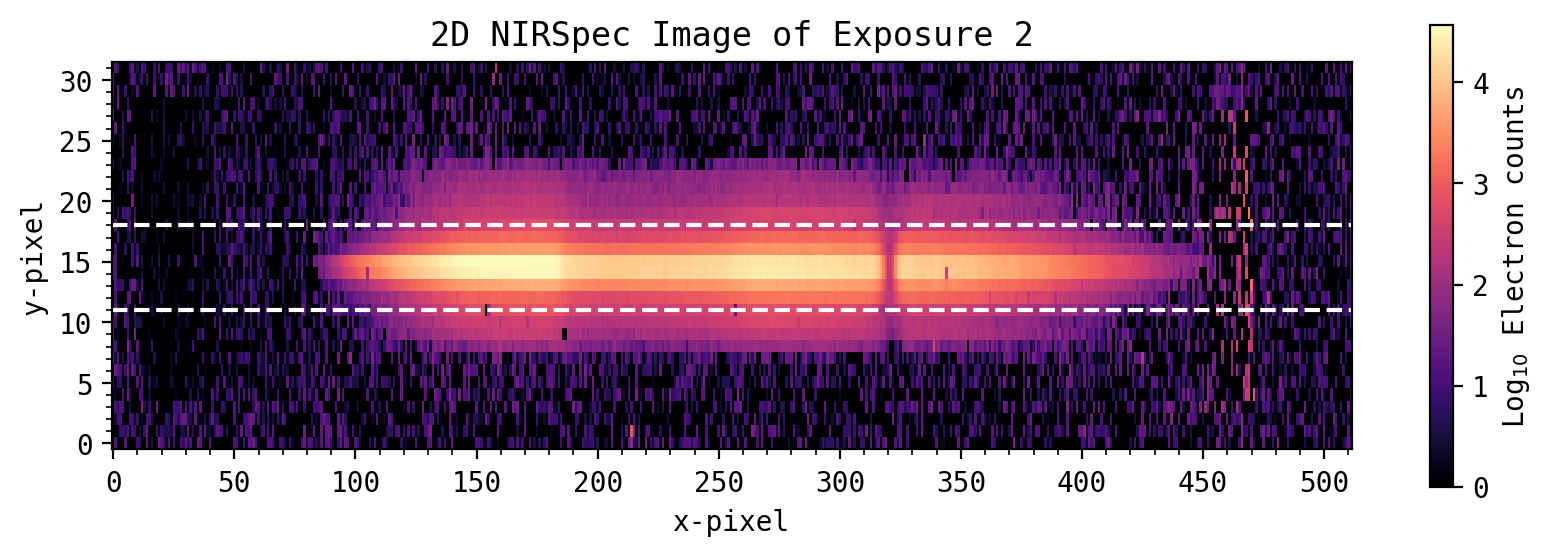

In [7]:
all_spec.shape
y_lower = 11                                             # Lower extraction aperature
y_upper = 18                                             # Upper extraction aperature
all_spec_1D=np.sum(all_spec[y_lower:y_upper,:,:],axis=0) # Sum along Y-axis from pixels 11 to 18

#Plot 

plt.rcParams['figure.figsize'] = [10.0, 3.0]           # Figure dimensions
plt.rcParams['figure.dpi']     = 200                   # Resolution
plt.rcParams['savefig.dpi']    = 200
plt.rcParams['image.aspect']   = 5                     # Aspect ratio (the CCD is quite long!!!)
plt.cmap = plt.cm.magma
plt.cmap.set_bad('k',1.)
plt.rcParams['image.cmap'] = 'magma'                   # Colormap.
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['font.family'] = "monospace"
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

img=all_spec[:,:,expnum]
zeros=np.where(img <= 0)     #Plot on a log scale, so set zero or negitive values to a small number 
img[zeros]=1E-10
fig,axs = plt.subplots()
f=axs.imshow(np.log10(img),vmin=0) #Plot image
plt.xlabel('x-pixel')
plt.ylabel('y-pixel')
axs.yaxis.set_major_locator(ticker.MultipleLocator(5))
axs.yaxis.set_minor_locator(ticker.MultipleLocator(1))
axs.xaxis.set_major_locator(ticker.MultipleLocator(50))
axs.xaxis.set_minor_locator(ticker.MultipleLocator(10))
plt.axhline(y_lower, color = 'w', ls = 'dashed')
plt.axhline(y_upper, color = 'w', ls = 'dashed')
plt.title('2D NIRSpec Image of Exposure '+str(expnum))
fig.colorbar(f,label='Log$_{10}$ Electron counts',ax=axs)
plt.show()



# Visualizing the 1D spectral data

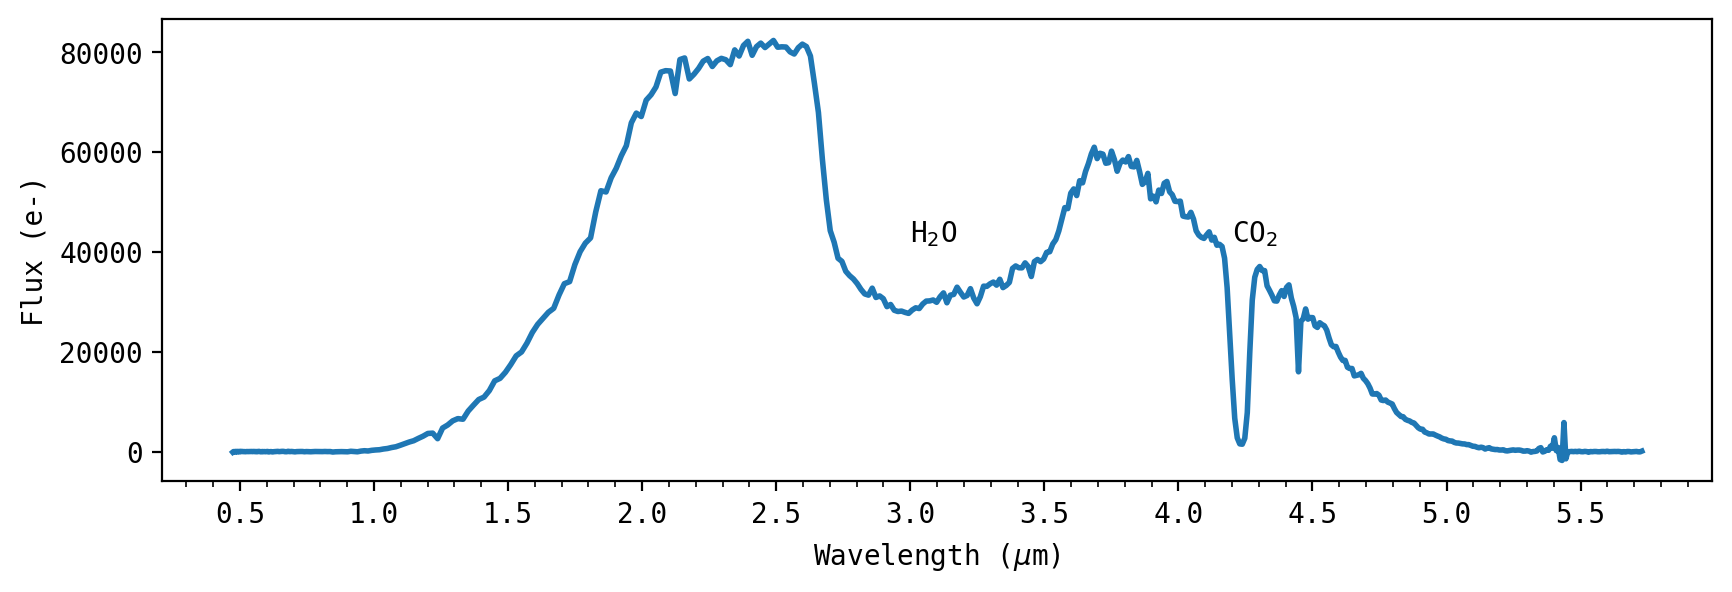

In [8]:
fig,axs = plt.subplots()
f=plt.plot(wsdata_all,all_spec_1D[:,0], linewidth=2,zorder=0)  #overplot Transit model at data
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (e-)')
axs.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.annotate('H$_2$O',xy=(3.0,42000))
plt.annotate('CO$_2$',xy=(4.2,42000))
plt.show()

The CV3 test observed a lamp with a similar PSF as JWST will have, and has significant counts from 
about 1.5 to 4.5 $\mu$m.

The cryogenic test chamber had CO$_2$ and H$_2$O ice buildup on the window, which can be seen as spectral absorption features in the 2D spectra.


## Calculate Orbital Phase and a separate fine grid model used for plotting purposes



In [9]:
#---------------------------------------------------------
#Calculate Orbital Phase
phase=(bjd-t0)/(per)  #phase in days relative to T0 ephemeris
phase=phase-np.fix(phase[number_of_images-1]) # Have current phase occur at value 0.0

t_fine = np.linspace(np.min(bjd), np.max(bjd), 1000) #times at which to calculate light curve
phase_fine=(t_fine-t0)/(per)  #phase in days relative to T0 ephemeris
phase_fine=phase_fine-np.fix(phase[number_of_images-1]) # Have current phase occur at value 0.0

b0=a_Rs * np.sqrt((np.sin(phase * 2* np.pi)) ** 2 + (np.cos(inc) * np.cos(phase * 2 * np.pi)) ** 2)
intransit=(b0-rp < 1.0E0).nonzero()  #Select indicies between first and fourth contact
outtransit=(b0-rp > 1.0E0).nonzero() #Select indicies out of transit


# Dealing with Systematic Drift On the Detector

The CV3 test assessed the stability of the instrument by introducing a large spatial jitter and drift. This resulted in a significant X,Y movement of the spectra on the 2D detector. While this bulk shift has been removed which aligns the spectra, intra- and inter- pixel sensitivities introduce flux variations which need to be removed. The jitter from the CV3 test was more than 30 mas, which is ~4X larger than the JWST stability requirement. Thus, in orbit these detector effects are expected to be significantly smaller, but they will still be present and will need to be modeled and removed from time series observations.

The detector X, Y positions here were measured from cross-correlation of the 2D images (collapsing the spectra along one dimension first), and are saved in arrays $shx$ and $shy$. These detending vectors would ideally be measured using the trace position values from the spectral extraction of each integration, as that could also accurately measure integration-to-integration how the spectra spatially changed on the detector.

The detector shifts have original amplitudes near 0.2 pixels, though the vectors have had initial normalization. For detrending purposes, these arrays should have a mean of 0 and standard deviation of 1.0.

A residual color-dependent trend with the LED lamp can also been seen in the CV3 data, which can be partly removed by scaling original common-mode lamp trend, which was measured using the CV3 white light curve.


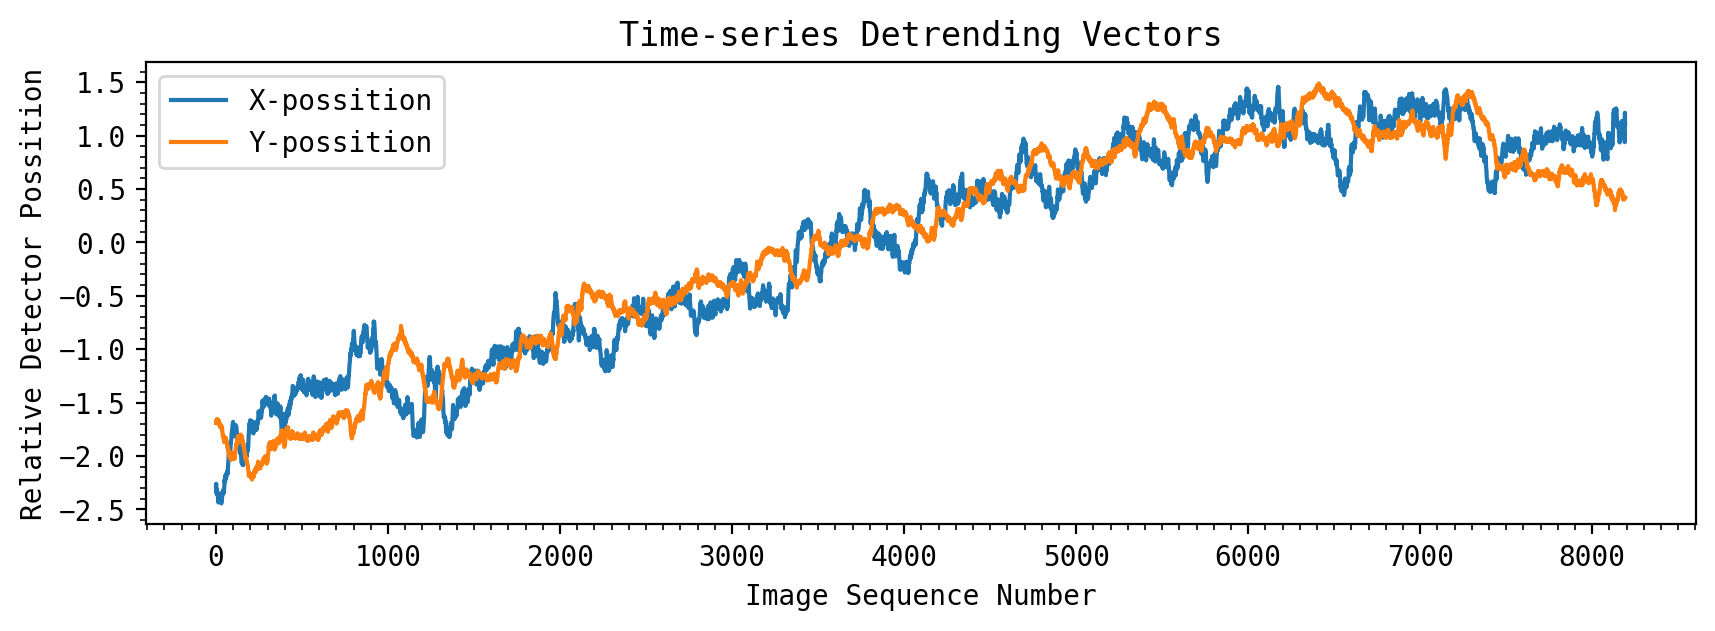

In [10]:
shx_tmp=shx/np.mean(shx)-1.0E0       #Set Mean around 0.0
shx_detrend=shx_tmp/np.std(shx_tmp)  #Set standard deviation to 1.0
shy_tmp=shy/np.mean(shy)-1.0E0       #Set Mean around 0.0
shy_detrend=shy_tmp/np.std(shy_tmp)  #Set standard deviation to 1.0

cm=common_mode/np.mean(common_mode)-1.0E0
cm_detrend=cm/np.std(cm)

fig,axs = plt.subplots()
plt.plot(shx_detrend,label='X-possition')
plt.plot(shy_detrend,label='Y-possition')
plt.xlabel('Image Sequence Number')
plt.ylabel('Relative Detector Possition')
plt.title('Time-series Detrending Vectors')
axs.xaxis.set_major_locator(ticker.MultipleLocator(1000))
axs.xaxis.set_minor_locator(ticker.MultipleLocator(100))
axs.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.legend()
plt.show()

## Create arrays of the vectors used for detrending.  

From Sing et al. 2019:  Systematic errors are often removed by a parameterized deterministic model, where the non-transit photometric trends are found to correlate with a number $n$ of external parameters (or optical state vectors, $X$). These parameters describe changes in the instrument or other external factors as a function of time during the observations, and are fit with a coefficient for each optical state parameter, $p_n$, to model and remove (or detrend) the photometric light curves.

When including systematic trends, the total parameterized model of the flux measurements over time, $f(t)$, can be modeled as a combination of the theoretical transit model, $T(t,\theta)$ (which depends upon the transit parameters $\theta$), the total baseline flux detected from the star, $F_0$, and the systematics error model $S(x)$ giving,

$f(t) = T(t,\theta)\times F_0 \times S(x)$.

We will use a linear model for the instrument systematic effects.

$S(x)= p_1 x + p_2 y + p_3 x^2 + p_4 y^2 + p_5 x y + p_6 cm + p_7 \phi $

$cm$ is the common_mode trend, and $\phi$ is a linear time trend which helps remove changing H$_2$O ice within the H$_2$O spectral feature.

In [11]:
shx=shx_detrend
shy=shy_detrend
common_mode=cm_detrend

XX=np.array([shx,shy,shx**2,shy**2,shx*shy,common_mode,np.ones(number_of_images)])  #Detrending array without linear time trend
XX=np.transpose(XX)
XXX=np.array([shx,shy,shx**2,shy**2,shx*shy,common_mode,phase,np.ones(number_of_images)])  #Detrending array with with linear time trend
XXX=np.transpose(XXX)



**Linear Regression** can be used to quickly determine the parameters $p_n$ using the out-of-transit data.

Here, we take a wavelength bin of the data (pixels 170 to 200) to make a time series.  The out-of-transit points are selected and a linear regression of $S(x)$ is done to determine the optical state parameters $p_n$

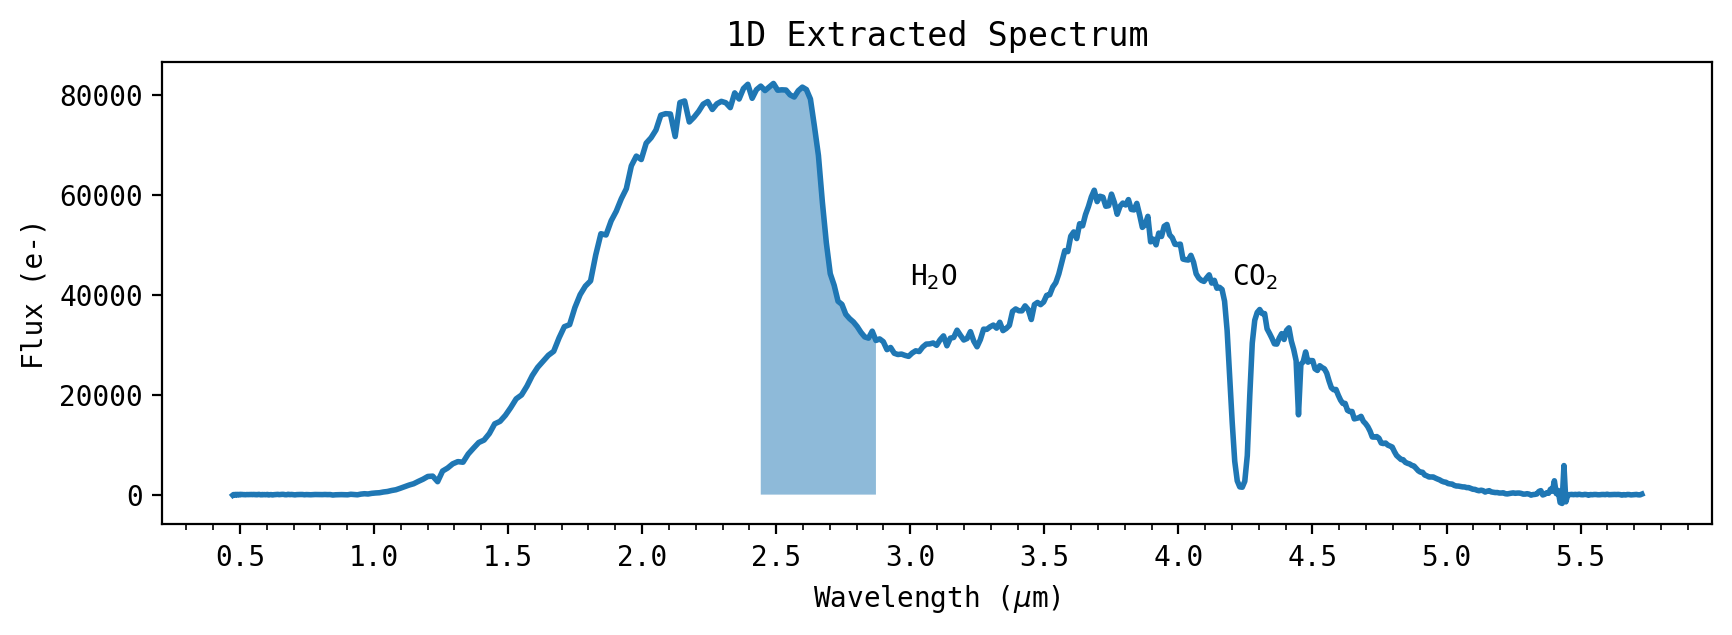

/tmp/ipykernel_1847/2418561847.py:21: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(bjd,y/np.mean(y[outtransit]),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.4, marker='+',edgecolors='blue')


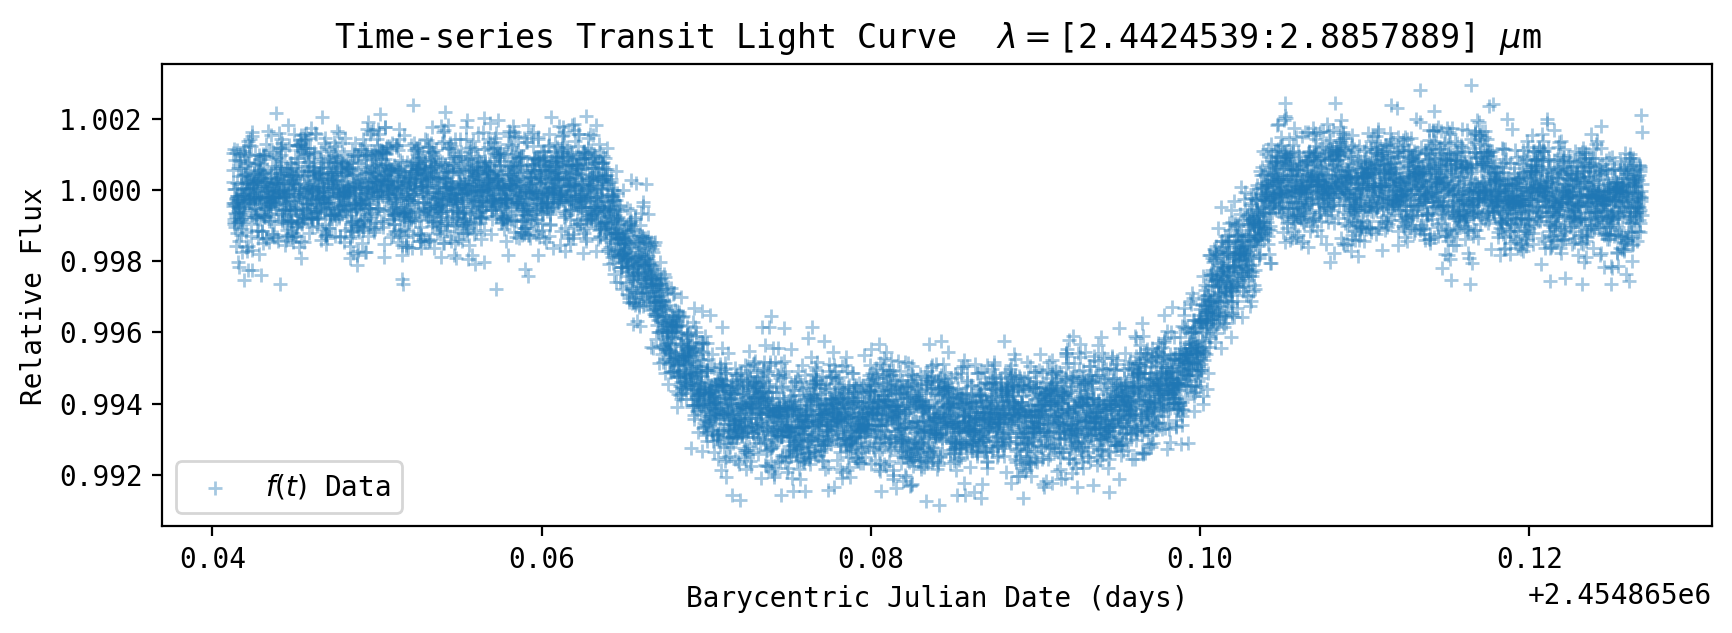

Linear Regression Coefficients:
[ 2.35589645e-04  2.33200386e-04 -1.43527088e-04 -4.65560797e-05
  1.94065907e-04 -4.51855007e-04  0.00000000e+00]


In [12]:
pix1=170       # wavelength bin lower range
pix2=200       # wavelength bin upper range
y=np.sum(all_spec_1D[pix1:pix2,:],axis=0)    # flux over a selected wavelength bin

msize=plt.rcParams['lines.markersize'] ** 2.           # default marker size
plt.rcParams['figure.figsize'] = [10.0, 3.0]           # Figure dimensions

fig,axs = plt.subplots()
f=plt.plot(wsdata_all,all_spec_1D[:,0], linewidth=2,zorder=0)  #Plot Region of wavelength bin
plt.fill_between(wsdata_all[pix1:pix2],0,all_spec_1D[pix1:pix2,0],alpha=0.5)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Flux (e-)')
plt.title('1D Extracted Spectrum')
axs.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
plt.annotate('H$_2$O',xy=(3.0,42000))
plt.annotate('CO$_2$',xy=(4.2,42000))
plt.show()

fig,axs = plt.subplots()
plt.scatter(bjd,y/np.mean(y[outtransit]),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.4, marker='+',edgecolors='blue')
plt.xlabel('Barycentric Julian Date (days)')
plt.ylabel('Relative Flux')
plt.title('Time-series Transit Light Curve  $\lambda=$['+str(wsdata_all[pix1])+':'+str(wsdata_all[pix2])+'] $\mu$m')
plt.legend()
plt.show()

regressor = LinearRegression()
regressor.fit(XX[outtransit], y[outtransit]/np.mean(y[outtransit]))
print('Linear Regression Coefficients:')
print(regressor.coef_)

The coefficients are on the order of ~10$^{-4}$ so the trends have an amplitude on the order of 100's of ppm.

Visualize the fit

/tmp/ipykernel_1847/1240295343.py:5: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(bjd,y/np.mean(y[outtransit]),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue')


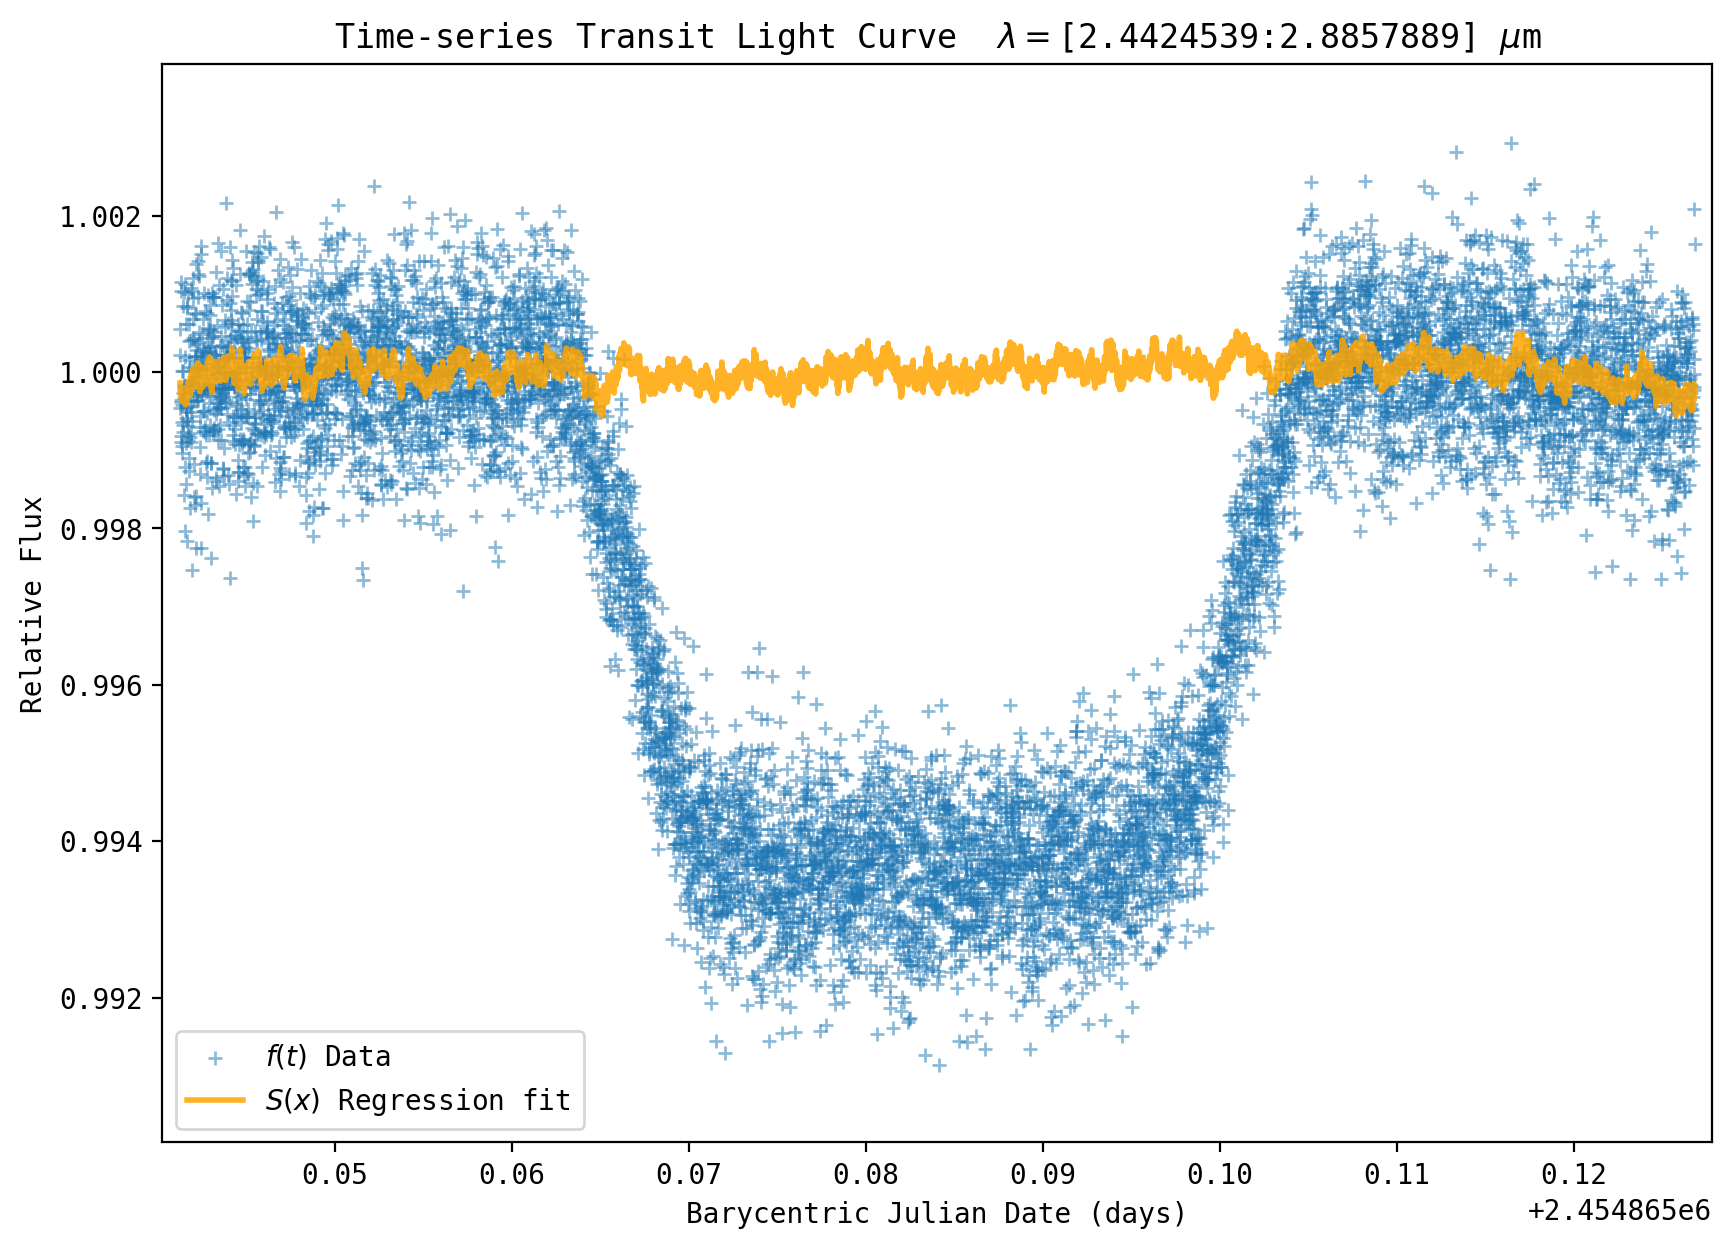

In [13]:
yfit=regressor.predict(XX)                         # Project the fit over the whole time series

plt.rcParams['figure.figsize'] = [10.0, 7.0]           # Figure dimensions
msize=plt.rcParams['lines.markersize'] ** 2.           # default marker size
plt.scatter(bjd,y/np.mean(y[outtransit]),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue')
f=plt.plot(bjd,yfit,label='$S(x)$ Regression fit ', linewidth=2,color='orange',zorder=2,alpha=0.85)
plt.xlabel('Barycentric Julian Date (days)')
plt.ylabel('Relative Flux')
plt.title('Time-series Transit Light Curve  $\lambda=$['+str(wsdata_all[pix1])+':'+str(wsdata_all[pix2])+'] $\mu$m')
axs.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
axs.xaxis.set_minor_locator(ticker.MultipleLocator(0.005))
axs.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
axs.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
yplot=y/np.mean(y[outtransit])
plt.ylim(yplot.min()*0.999, yplot.max()*1.001)
plt.xlim(bjd.min()-0.001, bjd.max()+0.001)
plt.legend(loc='lower left')
plt.show()

# Transit and Limb-Darkening Model Functions

Define a functions used by the fitting routines. 
These which will take the transit and systematic parameters and create our full transit light curve model

$model = T(t,\theta)\times F_0 \times S(x)$

compares it to the data

$y = f(t)$

by returning the residuals 

$(y-model)/(\sigma_y)$

To calculate the transit model, here we use  __[Mandel and Agol (2002)](https://ui.adsabs.harvard.edu/abs/2002ApJ...580L.171M/abstract)__ as coded in python by H. Wakeford (__[ExoTiC-ISM](https://github.com/hrwakeford/ExoTiC-ISM)__).

To calculate the stellar limb-darkening, we use the procedure from Sing et al. (2010) which uses stellar models and fits for non-linear limb darkening coefficients, with a module as coded in python by H. Wakeford (__[ExoTiC-ISM](https://github.com/hrwakeford/ExoTiC-ISM)__).

A new orbit is first calculated based on the system parameters of $a/R_{star}$, the cosine of the inclination $cos(i)$, and the orbital phase $\phi$. 
The inputs are the orbit distance between the planet-star center $b$ at each phase, limb-darkening parameters ($c_1,c_2,c_3,c_4$), and the planet-to-star radius ratio $R_p/R_{star}$.


In [14]:
@custom_model
def nonlinear_limb_darkening(x, c0=0.0, c1=0.0, c2=0.0, c3=0.0):
    """
    Define non-linear limb darkening model with four parameters c0, c1, c2, c3.
    """
    model = (1. - (c0 * (1. - x ** (1. / 2)) + c1 * (1. - x ** (2. / 2)) + c2 * (1. - x ** (3. / 2)) + c3 *
                   (1. - x ** (4. / 2))))
    return model


@custom_model
def quadratic_limb_darkening(x, aLD=0.0, bLD=0.0):
    """
    Define linear limb darkening model with parameters aLD and bLD.
    """
    model = 1. - aLD * (1. - x) - bLD * (1. - x) ** (4. / 2.)
    return model


def limb_dark_fit(grating, wsdata, M_H, Teff, logg, dirsen, ld_model='1D'):
    """
    Calculates stellar limb-darkening coefficients for a given wavelength bin.

    Currently supports:
    HST STIS G750L, G750M, G430L gratings
    HST WFC3 UVIS/G280, IR/G102, IR/G141 grisms

    What is used for 1D models - Kurucz (?)
    Procedure from Sing et al. (2010, A&A, 510, A21).
    Uses 3D limb darkening from Magic et al. (2015, A&A, 573, 90).
    Uses photon FLUX Sum over (lambda*dlamba).
    :param grating: string; grating to use ('G430L','G750L','G750M', 'G280', 'G102', 'G141')
    :param wsdata: array; data wavelength solution
    :param M_H: float; stellar metallicity
    :param Teff: float; stellar effective temperature (K)
    :param logg: float; stellar gravity
    :param dirsen: string; path to main limb darkening directory
    :param ld_model: string; '1D' or '3D', makes choice between limb darkening models; default is 1D
    :return: uLD: float; linear limb darkening coefficient
    aLD, bLD: float; quadratic limb darkening coefficients
    cp1, cp2, cp3, cp4: float; three-parameter limb darkening coefficients
    c1, c2, c3, c4: float; non-linear limb-darkening coefficients
    """

    print('You are using the', str(ld_model), 'limb darkening models.')

    if ld_model == '1D':

        direc = os.path.join(dirsen, 'Kurucz')

        print('Current Directories Entered:')
        print('  ' + dirsen)
        print('  ' + direc)

        # Select metallicity
        M_H_Grid = np.array([-0.1, -0.2, -0.3, -0.5, -1.0, -1.5, -2.0, -2.5, -3.0, -3.5, -4.0, -4.5, -5.0, 0.0, 0.1, 0.2, 0.3, 0.5, 1.0])
        M_H_Grid_load = np.array([0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 17, 20, 21, 22, 23, 24])
        optM = (abs(M_H - M_H_Grid)).argmin()
        MH_ind = M_H_Grid_load[optM]

        # Determine which model is to be used, by using the input metallicity M_H to figure out the file name we need
        direc = 'Kurucz'
        file_list = 'kuruczlist.sav'
        sav1 = readsav(os.path.join(dirsen, file_list))
        model = bytes.decode(sav1['li'][MH_ind])  # Convert object of type "byte" to "string"

        # Select Teff and subsequently logg
        Teff_Grid = np.array([3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750, 6000, 6250, 6500])
        optT = (abs(Teff - Teff_Grid)).argmin()

        logg_Grid = np.array([4.0, 4.5, 5.0])
        optG = (abs(logg - logg_Grid)).argmin()

        if logg_Grid[optG] == 4.0:
            Teff_Grid_load = np.array([8, 19, 30, 41, 52, 63, 74, 85, 96, 107, 118, 129, 138])

        elif logg_Grid[optG] == 4.5:
            Teff_Grid_load = np.array([9, 20, 31, 42, 53, 64, 75, 86, 97, 108, 119, 129, 139])

        elif logg_Grid[optG] == 5.0:
            Teff_Grid_load = np.array([10, 21, 32, 43, 54, 65, 76, 87, 98, 109, 120, 130, 140])

        # Where in the model file is the section for the Teff we want? Index T_ind tells us that.
        T_ind = Teff_Grid_load[optT]
        header_rows = 3    #  How many rows in each section we ignore for the data reading
        data_rows = 1221   # How  many rows of data we read
        line_skip_data = (T_ind + 1) * header_rows + T_ind * data_rows   # Calculate how many lines in the model file we need to skip in order to get to the part we need (for the Teff we want).
        line_skip_header = T_ind * (data_rows + header_rows)

        # Read the header, in case we want to have the actual Teff, logg and M_H info.
        # headerinfo is a pandas object.
        headerinfo = pd.read_csv(os.path.join(dirsen, direc, model), delim_whitespace=True, header=None,
                                 skiprows=line_skip_header, nrows=1)

        Teff_model = headerinfo[1].values[0]
        logg_model = headerinfo[3].values[0]
        MH_model = headerinfo[6].values[0]
        MH_model = float(MH_model[1:-1])

        print('\nClosest values to your inputs:')
        print('Teff: ', Teff_model)
        print('M_H: ', MH_model)
        print('log(g): ', logg_model)

        # Read the data; data is a pandas object.
        data = pd.read_csv(os.path.join(dirsen, direc, model), delim_whitespace=True, header=None,
                              skiprows=line_skip_data, nrows=data_rows)

        # Unpack the data
        ws = data[0].values * 10   # Import wavelength data
        f0 = data[1].values / (ws * ws)
        f1 = data[2].values * f0 / 100000.
        f2 = data[3].values * f0 / 100000.
        f3 = data[4].values * f0 / 100000.
        f4 = data[5].values * f0 / 100000.
        f5 = data[6].values * f0 / 100000.
        f6 = data[7].values * f0 / 100000.
        f7 = data[8].values * f0 / 100000.
        f8 = data[9].values * f0 / 100000.
        f9 = data[10].values * f0 / 100000.
        f10 = data[11].values * f0 / 100000.
        f11 = data[12].values * f0 / 100000.
        f12 = data[13].values * f0 / 100000.
        f13 = data[14].values * f0 / 100000.
        f14 = data[15].values * f0 / 100000.
        f15 = data[16].values * f0 / 100000.
        f16 = data[17].values * f0 / 100000.

        # Make single big array of them
        fcalc = np.array([f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, f12, f13, f14, f15, f16])
        phot1 = np.zeros(fcalc.shape[0])

        # Define mu
        mu = np.array([1.000, .900, .800, .700, .600, .500, .400, .300, .250, .200, .150, .125, .100, .075, .050, .025, .010])

        # Passed on to main body of function are: ws, fcalc, phot1, mu

    elif ld_model == '3D':

        direc = os.path.join(dirsen, '3DGrid')

        print('Current Directories Entered:')
        print('  ' + dirsen)
        print('  ' + direc)

        # Select metallicity
        M_H_Grid = np.array([-3.0, -2.0, -1.0, 0.0])  # Available metallicity values in 3D models
        M_H_Grid_load = ['30', '20', '10', '00']  # The according identifiers to individual available M_H values
        optM = (abs(M_H - M_H_Grid)).argmin()  # Find index at which the closes M_H values from available values is to the input M_H.

        # Select Teff
        Teff_Grid = np.array([4000, 4500, 5000, 5500, 5777, 6000, 6500, 7000])  # Available Teff values in 3D models
        optT = (abs(Teff - Teff_Grid)).argmin()  # Find index at which the Teff values is, that is closest to input Teff.

        # Select logg, depending on Teff. If several logg possibilities are given for one Teff, pick the one that is
        # closest to user input (logg).

        if Teff_Grid[optT] == 4000:
            logg_Grid = np.array([1.5, 2.0, 2.5])
            optG = (abs(logg - logg_Grid)).argmin()

        elif Teff_Grid[optT] == 4500:
            logg_Grid = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
            optG = (abs(logg - logg_Grid)).argmin()

        elif Teff_Grid[optT] == 5000:
            logg_Grid = np.array([2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
            optG = (abs(logg - logg_Grid)).argmin()

        elif Teff_Grid[optT] == 5500:
            logg_Grid = np.array([3.0, 3.5, 4.0, 4.5, 5.0])
            optG = (abs(logg - logg_Grid)).argmin()

        elif Teff_Grid[optT] == 5777:
            logg_Grid = np.array([4.4])
            optG = 0

        elif Teff_Grid[optT] == 6000:
            logg_Grid = np.array([3.5, 4.0, 4.5])
            optG = (abs(logg - logg_Grid)).argmin()

        elif Teff_Grid[optT] == 6500:
            logg_Grid = np.array([4.0, 4.5])
            optG = (abs(logg - logg_Grid)).argmin()

        elif Teff_Grid[optT] == 7000:
            logg_Grid = np.array([4.5])
            optG = 0

        # Select Teff and Log g. Mtxt, Ttxt and Gtxt are then put together as string to load correct files.
        Mtxt = M_H_Grid_load[optM]
        Ttxt = "{:2.0f}".format(Teff_Grid[optT] / 100)
        if Teff_Grid[optT] == 5777:
            Ttxt = "{:4.0f}".format(Teff_Grid[optT])
        Gtxt = "{:2.0f}".format(logg_Grid[optG] * 10)

        #
        file = 'mmu_t' + Ttxt + 'g' + Gtxt + 'm' + Mtxt + 'v05.flx'
        print('Filename:', file)

        # Read data from IDL .sav file
        sav = readsav(os.path.join(direc, file))  # readsav reads an IDL .sav file
        ws = sav['mmd'].lam[0]  # read in wavelength
        flux = sav['mmd'].flx  # read in flux
        Teff_model = Teff_Grid[optT]
        logg_model = logg_Grid[optG]
        MH_model = str(M_H_Grid[optM])

        print('\nClosest values to your inputs:')
        print('Teff  : ', Teff_model)
        print('M_H   : ', MH_model)
        print('log(g): ', logg_model)

        f0 = flux[0]
        f1 = flux[1]
        f2 = flux[2]
        f3 = flux[3]
        f4 = flux[4]
        f5 = flux[5]
        f6 = flux[6]
        f7 = flux[7]
        f8 = flux[8]
        f9 = flux[9]
        f10 = flux[10]

        # Make single big array of them
        fcalc = np.array([f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10])
        phot1 = np.zeros(fcalc.shape[0])

        # Mu from grid
        # 0.00000    0.0100000    0.0500000     0.100000     0.200000     0.300000   0.500000     0.700000     0.800000     0.900000      1.00000
        mu = sav['mmd'].mu

        # Passed on to main body of function are: ws, fcalc, phot1, mu

    ### Load response function and interpolate onto kurucz model grid

    # FOR STIS
    if grating == 'G430L':
        sav = readsav(os.path.join(dirsen, 'G430L.STIS.sensitivity.sav'))  # wssens,sensitivity
        wssens = sav['wssens']
        sensitivity = sav['sensitivity']
        wdel = 3

    if grating == 'G750M':
        sav = readsav(os.path.join(dirsen, 'G750M.STIS.sensitivity.sav'))  # wssens, sensitivity
        wssens = sav['wssens']
        sensitivity = sav['sensitivity']
        wdel = 0.554

    if grating == 'G750L':
        sav = readsav(os.path.join(dirsen, 'G750L.STIS.sensitivity.sav'))  # wssens, sensitivity
        wssens = sav['wssens']
        sensitivity = sav['sensitivity']
        wdel = 4.882

    # FOR WFC3
    if grating == 'G141':  # http://www.stsci.edu/hst/acs/analysis/reference_files/synphot_tables.html
        sav = readsav(os.path.join(dirsen, 'G141.WFC3.sensitivity.sav'))  # wssens, sensitivity
        wssens = sav['wssens']
        sensitivity = sav['sensitivity']
        wdel = 1

    if grating == 'G102':  # http://www.stsci.edu/hst/acs/analysis/reference_files/synphot_tables.html
        sav = readsav(os.path.join(dirsen, 'G141.WFC3.sensitivity.sav'))  # wssens, sensitivity
        wssens = sav['wssens']
        sensitivity = sav['sensitivity']
        wdel = 1

    if grating == 'G280':  # http://www.stsci.edu/hst/acs/analysis/reference_files/synphot_tables.html
        sav = readsav(os.path.join(dirsen, 'G280.WFC3.sensitivity.sav'))  # wssens, sensitivity
        wssens = sav['wssens']
        sensitivity = sav['sensitivity']
        wdel = 1

    # FOR JWST
    if grating == 'NIRSpecPrism':  # http://www.stsci.edu/hst/acs/analysis/reference_files/synphot_tables.html
        sav = readsav(os.path.join(dirsen, 'NIRSpec.prism.sensitivity.sav'))  # wssens, sensitivity
        wssens = sav['wssens']
        sensitivity = sav['sensitivity']
        wdel = 12


    widek = np.arange(len(wsdata))
    wsHST = wssens
    wsHST = np.concatenate((np.array([wsHST[0] - wdel - wdel, wsHST[0] - wdel]),
                            wsHST,
                            np.array([wsHST[len(wsHST) - 1] + wdel,
                                      wsHST[len(wsHST) - 1] + wdel + wdel])))

    respoutHST = sensitivity / np.max(sensitivity)
    respoutHST = np.concatenate((np.zeros(2), respoutHST, np.zeros(2)))
    inter_resp = interp1d(wsHST, respoutHST, bounds_error=False, fill_value=0)
    respout = inter_resp(ws)  # interpolate sensitivity curve onto model wavelength grid

    wsdata = np.concatenate((np.array([wsdata[0] - wdel - wdel, wsdata[0] - wdel]), wsdata,
                             np.array([wsdata[len(wsdata) - 1] + wdel, wsdata[len(wsdata) - 1] + wdel + wdel])))
    respwavebin = wsdata / wsdata * 0.0
    widek = widek + 2  # need to add two indicies to compensate for padding with 2 zeros
    respwavebin[widek] = 1.0
    data_resp = interp1d(wsdata, respwavebin, bounds_error=False, fill_value=0)
    reswavebinout = data_resp(ws)  # interpolate data onto model wavelength grid

    # Integrate over the spectra to make synthetic photometric points.
    for i in range(fcalc.shape[0]):  # Loop over spectra at diff angles
        fcal = fcalc[i, :]
        Tot = int_tabulated(ws, ws * respout * reswavebinout)
        phot1[i] = (int_tabulated(ws, ws * respout * reswavebinout * fcal, sort=True)) / Tot

    if ld_model == '1D':
        yall = phot1 / phot1[0]
    elif ld_model == '3D':
        yall = phot1 / phot1[10]

    Co = np.zeros((6, 4))   # NOT-REUSED

    A = [0.0, 0.0, 0.0, 0.0]  # c1, c2, c3, c4      # NOT-REUSED
    x = mu[1:]     # wavelength
    y = yall[1:]   # flux
    weights = x / x   # NOT-REUSED

    # Start fitting the different models
    fitter = LevMarLSQFitter()

    # Fit a four parameter non-linear limb darkening model and get fitted variables, c1, c2, c3, c4.
    corot_4_param = nonlinear_limb_darkening()
    corot_4_param = fitter(corot_4_param, x, y)
    c1, c2, c3, c4 = corot_4_param.parameters

    # Fit a three parameter non-linear limb darkening model and get fitted variables, cp2, cp3, cp4 (cp1 = 0).
    corot_3_param = nonlinear_limb_darkening()
    corot_3_param.c0.fixed = True  # 3 param is just 4 param with c0 = 0.0
    corot_3_param = fitter(corot_3_param, x, y)
    cp1, cp2, cp3, cp4 = corot_3_param.parameters

    # Fit a quadratic limb darkening model and get fitted parameters aLD and bLD.
    quadratic = quadratic_limb_darkening()
    quadratic = fitter(quadratic, x, y)
    aLD, bLD = quadratic.parameters

    # Fit a linear limb darkening model and get fitted variable uLD.
    linear = nonlinear_limb_darkening()
    linear.c0.fixed = True
    linear.c2.fixed = True
    linear.c3.fixed = True
    linear = fitter(linear, x, y)
    uLD = linear.c1.value

    print('\nLimb darkening parameters:')
    print("4param \t{:0.8f}\t{:0.8f}\t{:0.8f}\t{:0.8f}".format(c1, c2, c3, c4))
    print("3param \t{:0.8f}\t{:0.8f}\t{:0.8f}".format(cp2, cp3, cp4))
    print("Quad \t{:0.8f}\t{:0.8f}".format(aLD, bLD))
    print("Linear \t{:0.8f}".format(uLD))

    return uLD, c1, c2, c3, c4, cp1, cp2, cp3, cp4, aLD, bLD


def int_tabulated(X, F, sort=False):
    Xsegments = len(X) - 1

    # Sort vectors into ascending order.
    if not sort:
        ii = np.argsort(X)
        X = X[ii]
        F = F[ii]

    while (Xsegments % 4) != 0:
        Xsegments = Xsegments + 1

    Xmin = np.min(X)
    Xmax = np.max(X)

    # Uniform step size.
    h = (Xmax + 0.0 - Xmin) / Xsegments
    # Compute the interpolates at Xgrid.
    # x values of interpolates >> Xgrid = h * FINDGEN(Xsegments + 1L) + Xmin
    z = splev(h * np.arange(Xsegments + 1) + Xmin, splrep(X, F))

    # Compute the integral using the 5-point Newton-Cotes formula.
    ii = (np.arange((len(z) - 1) / 4, dtype=int) + 1) * 4

    return np.sum(2.0 * h * (7.0 * (z[ii - 4] + z[ii]) + 32.0 * (z[ii - 3] + z[ii - 1]) + 12.0 * z[ii - 2]) / 45.0)



## Now define the transit model function

In [15]:
def occultnl(rl, c1, c2, c3, c4, b0):
    """
    MANDEL & AGOL (2002) transit model.
    :param rl: float, transit depth (Rp/R*)
    :param c1: float, limb darkening parameter 1
    :param c2: float, limb darkening parameter 2
    :param c3: float, limb darkening parameter 3
    :param c4: float, limb darkening parameter 4
    :param b0: impact parameter in stellar radii
    :return: mulimb0: limb-darkened transit model, mulimbf: lightcurves for each component that you put in the model
    """
    mulimb0 = occultuniform(b0, rl)
    bt0 = b0
    fac = np.max(np.abs(mulimb0 - 1))
    if fac == 0:
        fac = 1e-6  # DKS edit

    omega = 4 * ((1 - c1 - c2 - c3 - c4) / 4 + c1 / 5 + c2 / 6 + c3 / 7 + c4 / 8)
    nb = len(b0)
    indx = np.where(mulimb0 != 1.0)[0]
    if len(indx) == 0:
        indx = -1
    mulimb = mulimb0[indx]
    mulimbf = np.zeros((5, nb))
    mulimbf[0, :] = mulimbf[0, :] + 1.
    mulimbf[1, :] = mulimbf[1, :] + 0.8
    mulimbf[2, :] = mulimbf[2, :] + 2 / 3
    mulimbf[3, :] = mulimbf[3, :] + 4 / 7
    mulimbf[4, :] = mulimbf[4, :] + 0.5
    nr = np.int64(2)
    dmumax = 1.0

    while (dmumax > fac * 1.e-3) and (nr <= 131072):
        #print(nr)
        mulimbp = mulimb
        nr = nr * 2
        dt = 0.5 * np.pi / nr
        t = dt * np.arange(nr + 1)
        th = t + 0.5 * dt
        r = np.sin(t)
        sig = np.sqrt(np.cos(th[nr - 1]))
        mulimbhalf = sig ** 3 * mulimb0[indx] / (1 - r[nr - 1])
        mulimb1 = sig ** 4 * mulimb0[indx] / (1 - r[nr - 1])
        mulimb3half = sig ** 5 * mulimb0[indx] / (1 - r[nr - 1])
        mulimb2 = sig ** 6 * mulimb0[indx] / (1 - r[nr - 1])
        for i in range(1, nr):
            mu = occultuniform(b0[indx] / r[i], rl / r[i])
            sig1 = np.sqrt(np.cos(th[i - 1]))
            sig2 = np.sqrt(np.cos(th[i]))
            mulimbhalf = mulimbhalf + r[i] ** 2 * mu * (sig1 ** 3 / (r[i] - r[i - 1]) - sig2 ** 3 / (r[i + 1] - r[i]))
            mulimb1 = mulimb1 + r[i] ** 2 * mu * (sig1 ** 4 / (r[i] - r[i - 1]) - sig2 ** 4 / (r[i + 1] - r[i]))
            mulimb3half = mulimb3half + r[i] ** 2 * mu * (sig1 ** 5 / (r[i] - r[i - 1]) - sig2 ** 5 / (r[i + 1] - r[i]))
            mulimb2 = mulimb2 + r[i] ** 2 * mu * (sig1 ** 6 / (r[i] - r[i - 1]) - sig2 ** 6 / (r[i + 1] - r[i]))

        mulimb = ((1 - c1 - c2 - c3 - c4) * mulimb0[
            indx] + c1 * mulimbhalf * dt + c2 * mulimb1 * dt + c3 * mulimb3half * dt + c4 * mulimb2 * dt) / omega
        ix1 = np.where(mulimb + mulimbp != 0.)[0]
        if len(ix1) == 0:
            ix1 = -1

        #print(ix1)
        # python cannot index on single values so you need to use atlest_1d for the below to work when mulimb is a single value
        dmumax = np.max(np.abs(np.atleast_1d(mulimb)[ix1] - np.atleast_1d(mulimbp)[ix1]) / (
                np.atleast_1d(mulimb)[ix1] + np.atleast_1d(mulimbp)[ix1]))

    mulimbf[0, indx] = np.atleast_1d(mulimb0)[indx]
    mulimbf[1, indx] = mulimbhalf * dt
    mulimbf[2, indx] = mulimb1 * dt
    mulimbf[3, indx] = mulimb3half * dt
    mulimbf[4, indx] = mulimb2 * dt
    np.atleast_1d(mulimb0)[indx] = mulimb
    b0 = bt0

    return mulimb0, mulimbf


def occultuniform(b0, w):
    """
    Compute the lightcurve for occultation of a uniform source without microlensing (Mandel & Agol 2002).

    :param b0: array; impact parameter in units of stellar radii
    :param w: array; occulting star size in units of stellar radius
    :return: muo1: float; fraction of flux at each b0 for a uniform source
    """

    if np.abs(w - 0.5) < 1.0e-3:
        w = 0.5

    nb = len(np.atleast_1d(b0))
    muo1 = np.zeros(nb)


    for i in range(nb):
        # substitute z=b0(i) to shorten expressions
        z = np.atleast_1d(b0)[i]
        #z = z.value    # stripping it of astropy units
        if z >= 1+w:
            muo1[i] = 1.0
            continue

        if w >= 1 and z <= w-1:
            muo1[i] = 0.0
            continue

        if z >= np.abs(1-w) and z <= 1+w:
            kap1 = np.arccos(np.min(np.append((1 - w ** 2 + z ** 2) / 2 / z, 1.)))
            kap0 = np.arccos(np.min(np.append((w ** 2 + z ** 2 - 1) / 2 / w / z, 1.)))
            lambdae = w ** 2 * kap0 + kap1
            lambdae = (lambdae - 0.5 * np.sqrt(np.max(np.append(4. * z ** 2 - (1 + z ** 2 - w ** 2) ** 2, 0.)))) / np.pi
            muo1[i] = 1 - lambdae

        if z <= 1-w:
            muo1[i] = 1 - w ** 2
            continue

    return muo1


## Now define the function to generate the transit light curve and compare it to the data

In [16]:
#Functions to call and calculate models
def residual(p,phase,x,y,err,c1, c2, c3, c4):
    #calculate new orbit
    b0=p['a_Rs'].value * np.sqrt((np.sin(phase * 2* np.pi)) ** 2 + (p['cosinc'].value * np.cos(phase * 2 * np.pi)) ** 2)
    #Select indicies between first and fourth contact
    intransit=(b0-p['rprs'].value < 1.0E0).nonzero()
    #Make light curve model, set all values initially to 1.0
    light_curve=b0/b0
    mulimb0, mulimbf = occultnl(p['rprs'].value, c1, c2, c3, c4, b0[intransit])  #Madel and Agol
    light_curve[intransit]=mulimb0
    model=(light_curve)*p['f0'].value * (p['Fslope'].value*phase + p['xsh'].value*shx + p['x2sh'].value*shx**2. + p['ysh'].value*shy + p['y2sh'].value*shy**2. + p['xysh'].value*shy*shx +  p['comm'].value*common_mode + 1.0) # transit model is baseline flux X transit model X systematics model
    chi2now=np.sum((y-model)**2/err**2)
    res=np.std((y-model)/p['f0'].value)
    print("rprs: ",p['rprs'].value,"current chi^2=",chi2now,' scatter ',res,end="\r")
    return (y-model)/err
    #return np.sum((y-model)**2/err**2)

A function is also defined to return just the transit model $T(t,\theta)$

In [17]:
def model_fine(p):  #Make Transit model with a fine grid for plotting purposes
    b0=p['a_Rs'].value * np.sqrt((np.sin(phase_fine * 2* np.pi)) ** 2 + (p['cosinc'].value * np.cos(phase_fine * 2 * np.pi)) ** 2)
    mulimb0, mulimbf = occultnl(p['rprs'].value, c1, c2, c3, c4, b0)  #Madel and Agol
    model_fine=mulimb0
    return model_fine

Now add a transit model to the Example Light curve.  Here, we've compute the limb darkening coefficients, then use them in the transit light curve.

In [18]:
wave1=wsdata_all[pix1]
wave2=wsdata_all[pix2]
bin_wave_index = ((wsdata_all > wave1) & (wsdata_all <= wave2)).nonzero()
wsdata=wsdata_all[bin_wave_index]*1E4 # Select wavelength bin values (um=> angstroms)

_uLD, c1, c2, c3, c4, _cp1, _cp2, _cp3, _cp4, aLD, bLD = limb_dark_fit(grating,wsdata, M_H, Teff,logg, limb_dark_directory, ld_model)



You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.87682090	-0.73755228	0.57723174	-0.19560435
3param 	2.19231542	-3.11195060	1.36536769
Quad 	0.02781785	0.37167814
Linear 	0.34303525


Now run the transit model.

The transit parameters such as inclination and $a/R_{star}$ have been setup at the beginning of the notebook.

/tmp/ipykernel_1847/1205937125.py:16: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(bjd,y/np.mean(y[outtransit]),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/1205937125.py:32: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(bjd,1E6*(y/np.mean(y[outtransit])-model),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue')


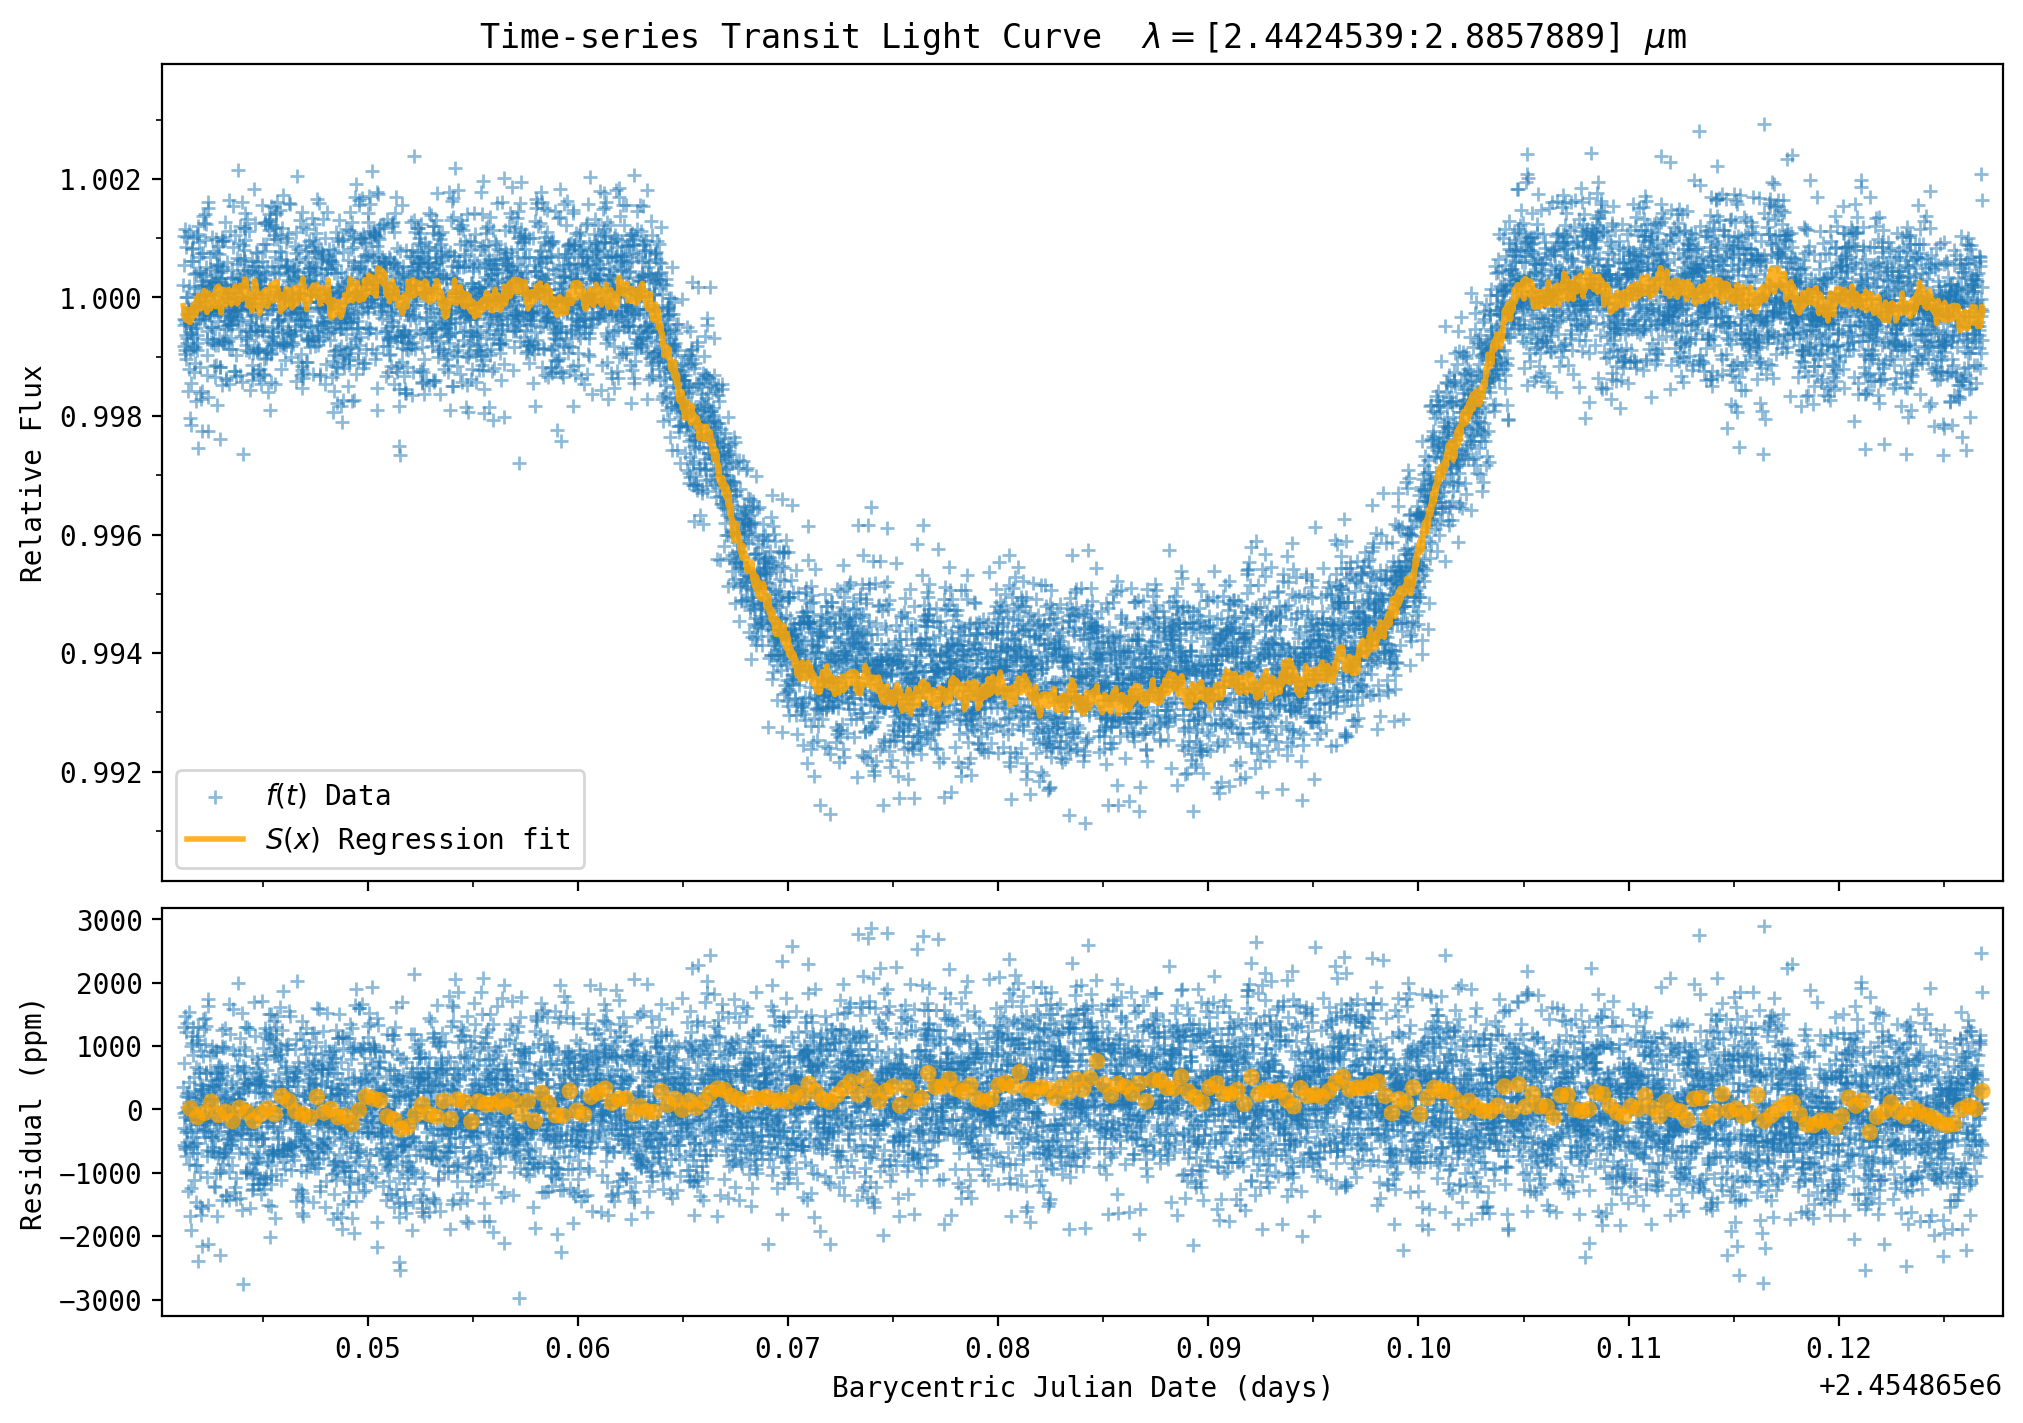

Chi^2 = 9265.443817708488
Residual Standard Deviation : 789.8093583096887 ppm
256 Bin Standard Deviation  :196.8330993569644 ppm


In [19]:
#Run the Transit Model
rl = 0.0825     # Planet-to-star Radius Ratio

b0=a_Rs * np.sqrt((np.sin(phase * 2* np.pi)) ** 2 + (np.cos(inc) * np.cos(phase * 2 * np.pi)) ** 2)
intransit=(b0-rl < 1.0E0).nonzero()  #Select indicies between first and fourth contact

mulimb0, mulimbf = occultnl(rl, c1, c2, c3, c4, b0)  #Mandel & Agol non-linear limb darkened transit model
model=mulimb0*yfit 

#plot
plt.rcParams['figure.figsize'] = [10.0, 7.0]           # Figure dimensions
msize=plt.rcParams['lines.markersize'] ** 2.           # default marker size
fig=plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 1,hspace=0.00, wspace=0.00)
ax1=fig.add_subplot(gs[0:2,:])
ax1.scatter(bjd,y/np.mean(y[outtransit]),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue')
ax1.plot(bjd,model,label='$S(x)$ Regression fit ', linewidth=2,color='orange',zorder=2,alpha=0.85)
ax1.xaxis.set_ticklabels([])
plt.ylabel('Relative Flux')
plt.title('Time-series Transit Light Curve  $\lambda=$['+str(wsdata_all[pix1])+':'+str(wsdata_all[pix2])+'] $\mu$m')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.005))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
yplot=y/np.mean(y[outtransit])
plt.ylim(yplot.min()*0.999, yplot.max()*1.001)
plt.xlim(bjd.min()-0.001, bjd.max()+0.001)
plt.legend()
fig.add_subplot(ax1)
#Residual
ax2=fig.add_subplot(gs[2,:])
ax2.scatter(bjd,1E6*(y/np.mean(y[outtransit])-model),label='$f(t)$ Data',zorder=1,s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue')
wsb, wsb_bin_edges,binnumber = stats.binned_statistic(bjd,1E6*(y/np.mean(y[outtransit])-model), bins=256)
plt.scatter(wsb_bin_edges[1:],wsb, linewidth=2,alpha=0.75,facecolors='orange',edgecolors='none', marker='o',zorder=25)
plt.xlabel('Barycentric Julian Date (days)')
plt.ylabel('Residual (ppm)')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.005))
yplot=y/np.mean(y[outtransit])
plt.xlim(bjd.min()-0.001, bjd.max()+0.001)
fig.add_subplot(ax2)
plt.show()

#print chi^2 value
err=np.sqrt(y)/np.mean(y[outtransit])
print('Chi^2 = '+str(np.sum((y/np.mean(y[outtransit])-model)**2/err**2)))

print('Residual Standard Deviation : '+str(1E6*np.std((y/np.mean(y[outtransit])-model)))+' ppm')
print('256 Bin Standard Deviation  :'+str(np.std(wsb))+' ppm')


Note that the model transit depth is a little too deep compared to the data. The planet radius needs to be smaller, and the parameter $rl$ is closer to 0.08.  As an exercise you can re-run the above cell changing the planet radius to $rl$=0.0805 and compare the $\chi^2$ value to the previous default value ($\chi^2$=9265.4 at $rl$ = 0.0825).

# FIT Transit Light Curves

Now we can fit each light curve, optimizing the fit parameters with a least-squares fit. Here a Levenberg-Marquart fit is used to find a $\chi^2$ minimum and estimate uncertainties using the lmfit package (https://lmfit.github.io/lmfit-py/fitting.html).

In practice, first we would fit the white light curve, which consists of summing over all of the wavelengths in the entire 1D spectra.  This can then be used to fit for the system parameters such as inclination and transit time, and then the spectroscopic channels are then fixed to these values as they are wavelength-independent.  However, the CV3 data required the overall variations of the lamp to be removed, which prevents our use of using this data for a white light curve analysis.  Here, we proceed to fitting for the spectroscopic light curve bins.

The steps are as follows:

    1) Wavelength Bin is selected
    
    2) Limb-darkening coefficients are calculated from a stellar model for each bin. 
    
    3) An initial linear regression is performed on the out-of-transit data to start the 
    systematic fit parameters, this greatly speeds up the fit as those parameters start 
    near their global minimum.
    
    4) The fit is started, and some statistics are output during the minimization
    
    5) Once the best-fit is found, a number of statistics are displayed 
    
    6) Finally, several plots are generated which are stored as PDFs and the next bin is started.

These steps are performed for each spectral bin.

In this example, the planet radius is set to vary in the fit along with the baseline flux and instrument systematic parameters. 

## Setup Wavelengths to fit over
The spectra must be binned in wavelength to get sufficient counts to reach ~100 ppm levels needed.
The spectra has significant counts from about pixel 100 to 400, we start at pixel $k0$ and bin the spectra by $wk$ pixels.

Several arrays are also defined.

In [20]:
k0   = 113 #98   #100
kend = 392 #422
wk   = 15
number_of_bins = int((kend-k0)/wk)
wsd  = np.zeros((number_of_bins))
werr = np.zeros((number_of_bins))
rprs = np.zeros((number_of_bins))
rerr = np.zeros((number_of_bins))
sig_r = np.zeros((number_of_bins))
sig_w = np.zeros((number_of_bins))
beta  = np.zeros((number_of_bins))
depth = np.zeros((number_of_bins))
depth_err = np.zeros((number_of_bins))

## Loop Over Wavelength Bins Fitting Each Lightcurve
### Note this step takes considerable time to complete (~20 min, few minutes/bin)
Each wavelength bin is fit for the transit+systematics model. Various outputs including plots are saved.
Can skip to the next cells to load pre-computed results.

In [21]:
k=k0   #wavelength to start
#--------------------------------------------------------------------------
#Loop over wavelength bins and fit for each one
for bin in range(0,number_of_bins):
    
    #---------------------------------------------------------
    # Select wavelength bin
    wave1=wsdata_all[k]
    wave2=wsdata_all[k+wk]

    #Indicies to select for wavelgth bin
    bin_wave_index = ((wsdata_all > wave1) & (wsdata_all <= wave2)).nonzero()

    #make light curve bin
    wave_bin_counts=np.sum(all_spec_1D[k+1:k+wk,:],axis=0) #Sum Wavelength pixels
    wave_bin_counts_err=np.sqrt(wave_bin_counts)           #adopt photon noise for errors
    #---------------------------------------------------------

    #---------------------------------------------------------
    # Calculate Limb Darkening

    wsdata=wsdata_all[bin_wave_index]*1E4 # Select wavelength bin values (um=> angstroms)
    _uLD, c1, c2, c3, c4, _cp1, _cp2, _cp3, _cp4, aLD, bLD = limb_dark_fit(grating,wsdata, M_H, Teff,logg, limb_dark_directory, ld_model)

    print('\nc1 = {}'.format(c1))
    print('c2 = {}'.format(c2))
    print('c3 = {}'.format(c3))
    print('c4 = {}'.format(c4))
    print('')
    #u   = [c1,c2,c3,c4]      #limb darkening coefficients
    u   = [aLD,bLD]
    #---------------------------------------------------------

    #---------------------------------------------------------
    # Make initial model
    
    #Setup LMFIT
    x=bjd                    # X data
    y=wave_bin_counts        # Y data
    err=wave_bin_counts_err  # Y Error

    #Perform Quick Linear regression on out-of-transit data to obtain accurate starting Detector fit values
    if wave1 > 2.7 and wave1 < 3.45:
        regressor.fit(XXX[outtransit], y[outtransit]/np.mean(y[outtransit]))
    else:
        regressor.fit(XX[outtransit], y[outtransit]/np.mean(y[outtransit]))

    # create a set of Parameters for LMFIT https://lmfit.github.io/lmfit-py/parameters.html
    #class Parameter(name, value=None, vary=True, min=- inf, max=inf, expr=None, brute_step=None, user_data=None)¶
    #Set vary=0 to fix
    #Set vary=1 to fit
    p = lmfit.Parameters()  #object to store L-M fit Parameters           # Parameter Name
    p.add('cosinc'  , value=np.cos(inc)           ,vary=0)                # inclination, vary cos(inclin)
    p.add('rho_star', value=rho_star              ,vary=0)                # stellar density
    p.add('a_Rs'    , value=a_Rs                  ,vary=0)                # a/Rstar
    p.add('rprs'    , value=rp                     ,vary=1, min=0, max=1)  # planet-to-star radius ratio
    p.add('t0'      , value=t0                    ,vary=0)                # Transit T0
    p.add('f0'      , value=np.mean(y[outtransit]),vary=1, min=0)         # Baseline Flux
    p.add('ecc'     , value=ecc                   ,vary=0, min=0 , max=1) # eccentricity
    p.add('omega'   , value=omega                 ,vary=0)                # arguments of periatron
    #Turn on a linear slope in water feature to account for presumably changing H2O ice builtup on widow during cryogenic test
    if wave1 > 2.7 and wave1 < 3.45:
        p.add('Fslope', value=regressor.coef_[6]  ,vary=1)                # Orbital phase
    else:
        p.add('Fslope', value=0                   ,vary=0)                # Orbital phase
    p.add('xsh'     , value=regressor.coef_[0]    ,vary=1)                # Detector X-shift detrending
    p.add('ysh'     , value=regressor.coef_[1]    ,vary=1)                # Detector X-shift detrending
    p.add('x2sh'    , value=regressor.coef_[2]    ,vary=1)                # Detector X^2-shift detrending
    p.add('y2sh'    , value=regressor.coef_[3]    ,vary=1)                # Detector Y^2-shift detrending
    p.add('xysh'    , value=regressor.coef_[4]    ,vary=1)                # Detector X*Y detrending
    p.add('comm'    , value=regressor.coef_[5]    ,vary=1)                # Common-Mode detrending
    
    #--------------------------------------------------------------------------
    # Perform Minimization https://lmfit.github.io/lmfit-py/fitting.html
    # create Minimizer
    # mini = lmfit.Minimizer(residual, p, nan_policy='omit',fcn_args=(phase,x,y,err)
    print('')
    print('Fitting Bin',bin,' Wavelength =',np.mean(wsdata)/1E4, '  Range= [',wave1,':',wave2,']')

    #  solve with Levenberg-Marquardt using the
    result = lmfit.minimize(residual,params=p,args=(phase,x,y,err,c1, c2, c3, c4))
    #result = mini.minimize(method='emcee')

    print('')
    print('Re-Fitting Bin',bin,' Wavelength =',np.mean(wsdata)/1E4, '  Range= [',wave1,':',wave2,']')
    #--------------------------------------------------------------------------
    print("")
    print("redchi",result.redchi)
    print("chi2",result.chisqr)
    print("nfree",result.nfree)
    print("bic",result.bic)
    print("aic",result.aic)
    print("L-M FIT Variable")
    print(lmfit.fit_report(result.params))
    text_file = open(save_directory+'JWST_NIRSpec_Prism_fit_light_curve_bin'+str(bin)+'_statistics.txt', "w")
    n = text_file.write("\nredchi "+str(result.redchi))
    n = text_file.write("\nchi2   "+str(result.chisqr))
    n = text_file.write("\nnfree  "+str(result.nfree))
    n = text_file.write("\nbic    "+str(result.bic))
    n = text_file.write("\naic    "+str(result.aic))
    n = text_file.write(lmfit.fit_report(result.params))
    # file-output.py

    #Update with best-fit parameters
    p['rho_star'].value = result.params['rho_star'].value
    p['cosinc'].value   = result.params['cosinc'].value
    p['rprs'].value     = result.params['rprs'].value
    p['t0'].value       = result.params['t0'].value
    p['f0'].value       = result.params['f0'].value
    p['Fslope'].value   = result.params['Fslope'].value
    p['xsh'].value      = result.params['xsh'].value
    p['ysh'].value      = result.params['ysh'].value
    p['x2sh'].value     = result.params['x2sh'].value
    p['y2sh'].value     = result.params['y2sh'].value
    p['xysh'].value     = result.params['xysh'].value
    p['comm'].value     = result.params['comm'].value
    # Update Fit Spectra arrays
    wsd[bin]=np.mean(wsdata)/1E4
    werr[bin]=(wsdata.max()-wsdata.min())/2E4
    rprs[bin]=result.params['rprs'].value
    rerr[bin]=result.params['rprs'].stderr

    # Calculate Bestfit Model
    final_model=y-result.residual*err
    final_model_fine=model_fine(p)

    #More Stats
    resid=(y-final_model)/p['f0'].value
    residppm=1E6*(y-final_model)/p['f0'].value
    residerr=err/p['f0'].value
    sigma=np.std((y-final_model)/p['f0'].value)*1E6
    print("Residual standard deviation  (ppm) : ",1E6*np.std((y-final_model)/p['f0'].value))
    print("Photon noise                 (ppm) : ", (1/np.sqrt(p['f0'].value))*1E6     )
    print("Photon noise performance       (%) : ", (1/np.sqrt(p['f0'].value))*1E6 / (sigma) *100 )
    n = text_file.write("\nResidual standard deviation  (ppm) : "+str(1E6*np.std((y-final_model)/p['f0'].value)))
    n = text_file.write("\nPhoton noise                 (ppm) : "+str((1/np.sqrt(p['f0'].value))*1E6))
    n = text_file.write("\nPhoton noise performance       (%) : "+str((1/np.sqrt(p['f0'].value))*1E6 / (sigma) *100 ))
 
    #Measure Rednoise with Binning Technique
    sig0=np.std(resid)
    bins=number_of_images/binmeasure
    wsb, wsb_bin_edges,binnumber = stats.binned_statistic(bjd,resid, bins=bins)
    sig_binned=np.std(wsb)
    sigrednoise=np.sqrt(sig_binned**2-sig0**2/binmeasure)
    if np.isnan(sigrednoise) == True : sigrednoise=0   #if no rednoise detected, set to zero
    sigwhite   =np.sqrt(sig0**2-sigrednoise**2)
    sigrednoise=np.sqrt(sig_binned**2-sigwhite**2/binmeasure)
    if np.isnan(sigrednoise) == True : sigrednoise=0   #if no rednoise detected, set to zero
    beta[bin]=np.sqrt(sig0**2+binmeasure*sigrednoise**2)/sig0
    
    print("White noise                  (ppm) : ",1E6*sigwhite)
    print("Red noise                    (ppm) : ",1E6*sigrednoise)
    print("Transit depth measured error (ppm) : ",2E6*result.params['rprs'].value*result.params['rprs'].stderr)
    
    n = text_file.write("\nWhite noise                  (ppm) : "+str(1E6*sigwhite))
    n = text_file.write("\nRed noise                    (ppm) : "+str(1E6*sigrednoise))
    n = text_file.write("\nTransit depth measured error (ppm) : "+str(2E6*result.params['rprs'].value*result.params['rprs'].stderr))
    text_file.close()
    depth[bin]=1E6*result.params['rprs'].value**2
    depth_err[bin]=2E6*result.params['rprs'].value*result.params['rprs'].stderr

    sig_r[bin]=sigrednoise*1E6
    sig_w[bin]=sigwhite*1E6
    #--------------------------------------------------------------------------
    #---------------------------------------------------------
    #Write Fit Spectra to ascii file
    ascii_data = Table([wsd, werr, rprs, rerr,depth,depth_err,sig_w,sig_r,beta], names=['Wavelength Center (um)', 'Wavelength half-width (um)','Rp/Rs','Rp/Rs 1-sigma error','Transit Depth (ppm)','Transit Depth error','Sigma_white (ppm)','Sigma_red (ppm)','Beta Rednoise Inflation factor'])
    ascii.write(ascii_data, save_directory+'JWST_NIRSpec_Prism_fit_transmission_spectra.csv', format='csv',overwrite=True)
    #---------------------------------------------------------
    msize=plt.rcParams['lines.markersize'] ** 2. #default marker size
    #Plot data models
     
    #plot
    plt.rcParams['figure.figsize'] = [10.0, 7.0]           # Figure dimensions
    msize=plt.rcParams['lines.markersize'] ** 2.           # default marker size
    fig=plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(3, 1,hspace=0.00, wspace=0.00)
    ax1=fig.add_subplot(gs[0:2,:])
    ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
    ax1.plot(x,final_model/p['f0'].value, linewidth=1,color='orange',alpha=0.8,zorder=15)  #overplot Transit model at data
    ax1.xaxis.set_ticklabels([])
    plt.ylabel('Relative Flux')
    plt.title('Time-series Transit Light Curve  $\lambda=$['+str(wave1)+':'+str(wave2)+'] $\mu$m')
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
    ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.005))
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.002))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.001))
    yplot=y/np.mean(y[outtransit])
    plt.ylim(yplot.min()*0.999, yplot.max()*1.001)
    plt.xlim(bjd.min()-0.001, bjd.max()+0.001)
    fig.add_subplot(ax1)
    #Residual
    ax2=fig.add_subplot(gs[2,:])
    ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
    wsb, wsb_bin_edges,binnumber = stats.binned_statistic(bjd,residppm, bins=256)
    plt.scatter(wsb_bin_edges[1:],wsb, linewidth=2,alpha=0.75,facecolors='orange',edgecolors='none', marker='o',zorder=25)
    plt.xlabel('Barycentric Julian Date (days)')
    plt.ylabel('Residual (ppm)')
    plt.plot([bjd.min(),bjd.max()],[0,0],color='black',zorder=10)
    plt.plot([bjd.min(),bjd.max()],[sigma,sigma],linestyle='--',color='black',zorder=15)
    plt.plot([bjd.min(),bjd.max()],[-sigma,-sigma],linestyle='--',color='black',zorder=20)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(0.01))
    ax2.xaxis.set_minor_locator(ticker.MultipleLocator(0.005))
    yplot=y/np.mean(y[outtransit])
    plt.xlim(bjd.min()-0.001, bjd.max()+0.001)
    fig.add_subplot(ax2)
    #save
    pp = PdfPages(save_directory+'JWST_NIRSpec_Prism_fit_light_curve_bin'+str(bin)+'_lightcurve.pdf')
    plt.savefig(pp,format='pdf')
    pp.close()
    plt.clf()   
    #--------------------------------------------------------------------------
    #plot systematic corrected light curve
    b0=p['a_Rs'].value * np.sqrt((np.sin(phase * 2* np.pi)) ** 2 + (p['cosinc'].value * np.cos(phase * 2 * np.pi)) ** 2)
    intransit=(b0-p['rprs'].value < 1.0E0).nonzero()
    light_curve=b0/b0
    mulimb0, mulimbf = occultnl(p['rprs'].value, c1, c2, c3, c4, b0[intransit])  #Madel and Agol
    light_curve[intransit]=mulimb0
    fig,axs = plt.subplots()
    plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
    plt.xlabel('BJD')
    plt.ylabel('Relative Flux')
    plt.plot(x,light_curve, linewidth=2,color='orange',alpha=0.8,zorder=15)  #overplot Transit model at data
    pp = PdfPages(save_directory+'JWST_NIRSpec_Prism_fit_light_curve_bin'+str(bin)+'_corrected.pdf')
    plt.savefig(pp,format='pdf')
    pp.close()
    plt.clf()
    plt.close('all') #close all figures
    #--------------------------------------------------------------------------
    k=k+wk  #step wavelength index to next bin
    
    print('** Can Now View Output PDFs in ',save_directory)


You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.93487505	-0.53100613	0.43228652	-0.16656941
3param 	2.59284758	-3.50115591	1.49775430
Quad 	0.08088643	0.45654030
Linear 	0.46807479

c1 = 0.9348750506824713
c2 = -0.5310061297363668
c3 = 0.4322865163299993
c4 = -0.1665694116744178


Fitting Bin 0  Wavelength = 1.5502650866666667   Range= [ 1.3906398 : 1.6900786 ]
rprs:  0.07869514560761881 current chi^2= 13085.41756955299  scatter  0.002392289287921359
Re-Fitting Bin 0  Wavelength = 1.5502650866666667   Range= [ 1.3906398 : 1.6900786 ]

redchi 1.598902440072457
chi2 13085.417569552988
nfree 8184
bic 3908.7316936329175
aic 3852.644386854683
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a_Rs:      14.54 (fixed)
    rprs:      0.078

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	1.12080976	-0.97843713	0.75312858	-0.25673953
3param 	2.76671119	-3.96262532	1.73859692
Quad 	0.01052393	0.47328324
Linear 	0.41191184

c1 = 1.1208097603789067
c2 = -0.9784371279899322
c3 = 0.7531285754201472
c4 = -0.25673952710770237


Fitting Bin 1  Wavelength = 1.84545072   Range= [ 1.6900786 : 1.9783379 ]
rprs:  0.08047594264216407 current chi^2= 14107.324261910102  scatter  0.0015893597542941287
Re-Fitting Bin 1  Wavelength = 1.84545072   Range= [ 1.6900786 : 1.9783379 ]

redchi 1.7237688492070018
chi2 14107.324261910102
nfree 8184
bic 4524.734590844106
aic 4468.647284065872
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a_Rs:     

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	1.05423283	-0.97018497	0.77456621	-0.26658145
3param 	2.55249877	-3.66106843	1.61023054
Quad 	0.01394080	0.43332492
Linear 	0.38144036

c1 = 1.0542328323187433
c2 = -0.9701849696940038
c3 = 0.7745662054908382
c4 = -0.2665814455066517


Fitting Bin 2  Wavelength = 2.1223476199999998   Range= [ 1.9783379 : 2.2448517 ]
rprs:  0.07999433237385567 current chi^2= 12525.31307868164  scatter  0.0012094149112738238
Re-Fitting Bin 2  Wavelength = 2.1223476199999998   Range= [ 1.9783379 : 2.2448517 ]

redchi 1.530463474912224
chi2 12525.31307868164
nfree 8184
bic 3550.3578704200004
aic 3494.270563641766
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
 

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.93455579	-0.84286559	0.70782403	-0.25114311
3param 	2.27992131	-3.22427512	1.41261223
Quad 	0.03322149	0.38713152
Linear 	0.36154478

c1 = 0.9345557878924728
c2 = -0.842865591448989
c3 = 0.7078240285892669
c4 = -0.25114311341177076


Fitting Bin 3  Wavelength = 2.377201606666667   Range= [ 2.2448517 : 2.4898652 ]
rprs:  0.08152564129493195 current chi^2= 10199.77117780952  scatter  0.0010540373464275419
Re-Fitting Bin 3  Wavelength = 2.377201606666667   Range= [ 2.2448517 : 2.4898652 ]

redchi 1.2463063511497459
chi2 10199.77117780952
nfree 8184
bic 1867.8328382181683
aic 1811.745531439934
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
  

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.87680367	-0.73477190	0.58280906	-0.20005969
3param 	2.19503822	-3.10630077	1.36088167
Quad 	0.03045602	0.37301051
Linear 	0.34680339

c1 = 0.8768036657166061
c2 = -0.7347718979202822
c3 = 0.5828090572726548
c4 = -0.20005969410091345


Fitting Bin 4  Wavelength = 2.6120002933333333   Range= [ 2.4898652 : 2.7162005 ]
rprs:  0.08079801922696833 current chi^2= 9205.709924232702  scatter  0.0010482768870632123
Re-Fitting Bin 4  Wavelength = 2.6120002933333333   Range= [ 2.4898652 : 2.7162005 ]

redchi 1.1248423661085902
chi2 9205.709924232702
nfree 8184
bic 1027.8140906871731
aic 971.7267839089388
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.86128574	-0.71348923	0.53201916	-0.17329851
3param 	2.16446825	-3.09179973	1.36001686
Quad 	0.02096721	0.36578104
Linear 	0.33118333

c1 = 0.8612857385257381
c2 = -0.7134892338976185
c3 = 0.5320191611801466
c4 = -0.17329850593840487


Fitting Bin 5  Wavelength = 2.82970062   Range= [ 2.7162005 : 2.9267646 ]
rprs:  0.07985696507406603 current chi^2= 9962.933845727543  scatter  0.0016130786363104184
Re-Fitting Bin 5  Wavelength = 2.82970062   Range= [ 2.7162005 : 2.9267646 ]

redchi 1.2175160510482146
chi2 9962.93384572754
nfree 8183
bic 1684.3833984795388
aic 1621.2851783540252
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a_Rs:      

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.83139630	-0.69648917	0.51398704	-0.16463361
3param 	2.08159374	-2.98407343	1.31547068
Quad 	0.01845846	0.35019596
Linear 	0.31545699

c1 = 0.8313962953707446
c2 = -0.6964891670743414
c3 = 0.5139870432910413
c4 = -0.16463361118129816


Fitting Bin 6  Wavelength = 3.03297832   Range= [ 2.9267646 : 3.1240093 ]
rprs:  0.07996217806229661 current chi^2= 9377.921035738203  scatter  0.0016759321967395931
Re-Fitting Bin 6  Wavelength = 3.03297832   Range= [ 2.9267646 : 3.1240093 ]

redchi 1.1460248118951732
chi2 9377.921035738203
nfree 8183
bic 1188.6568837002665
aic 1125.558663574753
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a_Rs:      

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.81389247	-0.73763493	0.57400093	-0.18855617
3param 	1.98195953	-2.85041302	1.26038669
Quad 	0.01890988	0.33067264
Linear 	0.29935083

c1 = 0.8138924681720138
c2 = -0.7376349257671482
c3 = 0.5740009254716998
c4 = -0.18855617475368763


Fitting Bin 7  Wavelength = 3.2240248533333333   Range= [ 3.1240093 : 3.3099063 ]
rprs:  0.081731930696132 current chi^2= 9016.09530809756  scatter  0.0015709991669595974
Re-Fitting Bin 7  Wavelength = 3.2240248533333333   Range= [ 3.1240093 : 3.3099063 ]

redchi 1.1018080542707516
chi2 9016.09530809756
nfree 8183
bic 866.328284808006
aic 803.2300646824924
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a

/tmp/ipykernel_1847/3598146454.py:144: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sig0**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:147: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sigwhite**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.77921338	-0.73484018	0.59159019	-0.19763154
3param 	1.86887525	-2.68691313	1.18957342
Quad 	0.02139147	0.31022264
Linear 	0.28448893

c1 = 0.7792133777907014
c2 = -0.7348401843860144
c3 = 0.5915901917273957
c4 = -0.19763153511838683


Fitting Bin 8  Wavelength = 3.4045925866666678   Range= [ 3.3099063 : 3.4860291 ]
rprs:  0.08227189111073568 current chi^2= 9103.12645273891  scatter  0.001486859846401247
Re-Fitting Bin 8  Wavelength = 3.4045925866666678   Range= [ 3.3099063 : 3.4860291 ]

redchi 1.112443657917501
chi2 9103.12645273891
nfree 8183
bic 945.0253314396016
aic 881.9271113140879
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.74674613	-0.70346448	0.56972787	-0.19098962
3param 	1.79176273	-2.57217104	1.13841509
Quad 	0.02245657	0.29733359
Linear 	0.27462292

c1 = 0.7467461281818586
c2 = -0.703464475253341
c3 = 0.5697278747363782
c4 = -0.19098961530866335


Fitting Bin 9  Wavelength = 3.576083346666666   Range= [ 3.4860291 : 3.6536426 ]
rprs:  0.08252602289830863 current chi^2= 9276.732530998435  scatter  0.0013166537622040565
Re-Fitting Bin 9  Wavelength = 3.576083346666666   Range= [ 3.4860291 : 3.6536426 ]

redchi 1.1335205927417442
chi2 9276.732530998435
nfree 8184
bic 1090.7733083166036
aic 1034.686001538369
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
  

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.72352161	-0.69353431	0.56713532	-0.19083063
3param 	1.72408895	-2.47704753	1.09722831
Quad 	0.02204262	0.28542380
Linear 	0.26410838

c1 = 0.7235216095303149
c2 = -0.6935343053856736
c3 = 0.5671353198452366
c4 = -0.19083063352760457


Fitting Bin 10  Wavelength = 3.739628686666667   Range= [ 3.6536426 : 3.8137721 ]
rprs:  0.08096454884929871 current chi^2= 8850.135154072294  scatter  0.0011470680982993307
Re-Fitting Bin 10  Wavelength = 3.739628686666667   Range= [ 3.6536426 : 3.8137721 ]

redchi 1.0813948135474454
chi2 8850.135154072294
nfree 8184
bic 705.1213399520465
aic 649.0340331738122
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)


/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.70158183	-0.68497822	0.56261757	-0.18898808
3param 	1.65933401	-2.38925471	1.06001228
Quad 	0.02095753	0.27363515
Linear 	0.25302542

c1 = 0.7015818333859046
c2 = -0.6849782192064447
c3 = 0.5626175733836511
c4 = -0.1889880833880477


Fitting Bin 11  Wavelength = 3.896151973333334   Range= [ 3.8137721 : 3.9672586 ]
rprs:  0.08035896949501908 current chi^2= 9206.088737154983  scatter  0.0012179575143233786
Re-Fitting Bin 11  Wavelength = 3.896151973333334   Range= [ 3.8137721 : 3.9672586 ]

redchi 1.1248886531225541
chi2 9206.088737154983
nfree 8184
bic 1028.1511827352492
aic 972.0638759570148
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)


/tmp/ipykernel_1847/3598146454.py:144: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sig0**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:147: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sigwhite**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.70601642	-0.70030861	0.58051914	-0.19676969
3param 	1.65882163	-2.39001144	1.06012540
Quad 	0.01948102	0.27394442
Linear 	0.25181120

c1 = 0.7060164155107614
c2 = -0.700308605577277
c3 = 0.5805191372829517
c4 = -0.1967696897622868


Fitting Bin 12  Wavelength = 4.046415566666666   Range= [ 3.9672586 : 4.1148019 ]
rprs:  0.08042004441010336 current chi^2= 9426.689204353297  scatter  0.0013248496064212911
Re-Fitting Bin 12  Wavelength = 4.046415566666666   Range= [ 3.9672586 : 4.1148019 ]

redchi 1.151843744422446
chi2 9426.689204353299
nfree 8184
bic 1222.136585991429
aic 1166.0492792131947
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
  

/tmp/ipykernel_1847/3598146454.py:144: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sig0**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:147: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sigwhite**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.70935323	-0.72091003	0.59985926	-0.20291388
3param 	1.64937007	-2.38471082	1.05992162
Quad 	0.01796001	0.27118947
Linear 	0.24795374

c1 = 0.7093532347748518
c2 = -0.7209100290636149
c3 = 0.5998592638096363
c4 = -0.2029138849439886


Fitting Bin 13  Wavelength = 4.191056326666667   Range= [ 4.1148019 : 4.2569868 ]
rprs:  0.08076799979284849 current chi^2= 10166.766846802619  scatter  0.0019237894693083638
Re-Fitting Bin 13  Wavelength = 4.191056326666667   Range= [ 4.1148019 : 4.2569868 ]

redchi 1.2422735638810631
chi2 10166.76684680262
nfree 8184
bic 1841.2822564792139
aic 1785.1949497009796
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed

/tmp/ipykernel_1847/3598146454.py:144: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sig0**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:147: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sigwhite**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.66323587	-0.66364687	0.56071310	-0.19136859
3param 	1.55253360	-2.22982036	0.98936587
Quad 	0.02366143	0.25528761
Linear 	0.24016891

c1 = 0.6632358693959266
c2 = -0.6636468698454744
c3 = 0.5607130986026022
c4 = -0.1913685852532563


Fitting Bin 14  Wavelength = 4.33061144   Range= [ 4.2569868 : 4.3943119 ]
rprs:  0.0811476098477178 current chi^2= 10258.192606422148  scatter  0.0016628191173589791
Re-Fitting Bin 14  Wavelength = 4.33061144   Range= [ 4.2569868 : 4.3943119 ]

redchi 1.2534448443819828
chi2 10258.192606422148
nfree 8184
bic 1914.6204510224563
aic 1858.533144244222
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a_Rs:    

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.60983174	-0.61629105	0.53858322	-0.18657597
3param 	1.42144129	-2.02725487	0.89908507
Quad 	0.03065179	0.23249928
Linear 	0.22783267

c1 = 0.6098317351531414
c2 = -0.6162910548658452
c3 = 0.5385832222369871
c4 = -0.1865759656282499


Fitting Bin 15  Wavelength = 4.465538639999999   Range= [ 4.3943119 : 4.5272022 ]
rprs:  0.08073844913704875 current chi^2= 10929.456415288822  scatter  0.0018686202314488576
Re-Fitting Bin 15  Wavelength = 4.465538639999999   Range= [ 4.3943119 : 4.5272022 ]

redchi 1.3354663264038147
chi2 10929.45641528882
nfree 8184
bic 2433.8695736839823
aic 2377.7822669057477
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed

/tmp/ipykernel_1847/3598146454.py:144: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sig0**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:147: RuntimeWarning: invalid value encountered in sqrt
  sigrednoise=np.sqrt(sig_binned**2-sigwhite**2/binmeasure)
/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.60997947	-0.64472844	0.57190253	-0.19852233
3param 	1.39349756	-1.99455717	0.88740172
Quad 	0.03077627	0.22593125
Linear 	0.22238684

c1 = 0.6099794722511525
c2 = -0.6447284371811377
c3 = 0.5719025262014379
c4 = -0.1985223297067249


Fitting Bin 16  Wavelength = 4.59623168   Range= [ 4.5272022 : 4.6560258 ]
rprs:  0.0802535082497412 current chi^2= 11816.07660241995  scatter  0.0022409846380202704
Re-Fitting Bin 16  Wavelength = 4.59623168   Range= [ 4.5272022 : 4.6560258 ]

redchi 1.4438021263953995
chi2 11816.07660241995
nfree 8184
bic 3072.8411538775404
aic 3016.753847099306
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a_Rs:      

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/
You are using the 3D limb darkening models.
Current Directories Entered:
  ./notebookrun2/
  ./notebookrun2/3DGrid
Filename: mmu_t45g45m00v05.flx

Closest values to your inputs:
Teff  :  4500
M_H   :  0.0
log(g):  4.5

Limb darkening parameters:
4param 	0.60350262	-0.62606713	0.54814049	-0.18913089
3param 	1.39051667	-1.99106813	0.88526265
Quad 	0.02900564	0.22612279
Linear 	0.22077866

c1 = 0.6035026150544636
c2 = -0.6260671293320387
c3 = 0.5481404929821063
c4 = -0.18913089064980246


Fitting Bin 17  Wavelength = 4.7230313   Range= [ 4.6560258 : 4.7811009 ]
rprs:  0.07993813104378789 current chi^2= 16280.793120699314  scatter  0.003335098304845015
Re-Fitting Bin 17  Wavelength = 4.7230313   Range= [ 4.6560258 : 4.7811009 ]

redchi 1.989344222959349
chi2 16280.793120699313
nfree 8184
bic 5698.5823530513135
aic 5642.495046273079
L-M FIT Variable
[[Variables]]
    cosinc:    0.05481076 (fixed)
    rho_star:  8.320569 (fixed)
    a_Rs:      

/tmp/ipykernel_1847/3598146454.py:179: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax1.scatter(x,y/p['f0'].value,s=msize*0.75, linewidth=1,zorder=0,alpha=0.5, marker='+',edgecolors='blue')
/tmp/ipykernel_1847/3598146454.py:194: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax2.scatter(x,residppm, s=msize*0.75,linewidth=1 ,alpha=0.5, marker='+',edgecolors='blue',zorder=0)  #overplot Transit model at data
/tmp/ipykernel_1847/3598146454.py:220: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,light_curve+resid,s=msize*0.75, linewidth=1,zord

** Can Now View Output PDFs in  ./notebookrun2/


# Plot Measured Exoplanet Transmission Spectrum vs Injected 

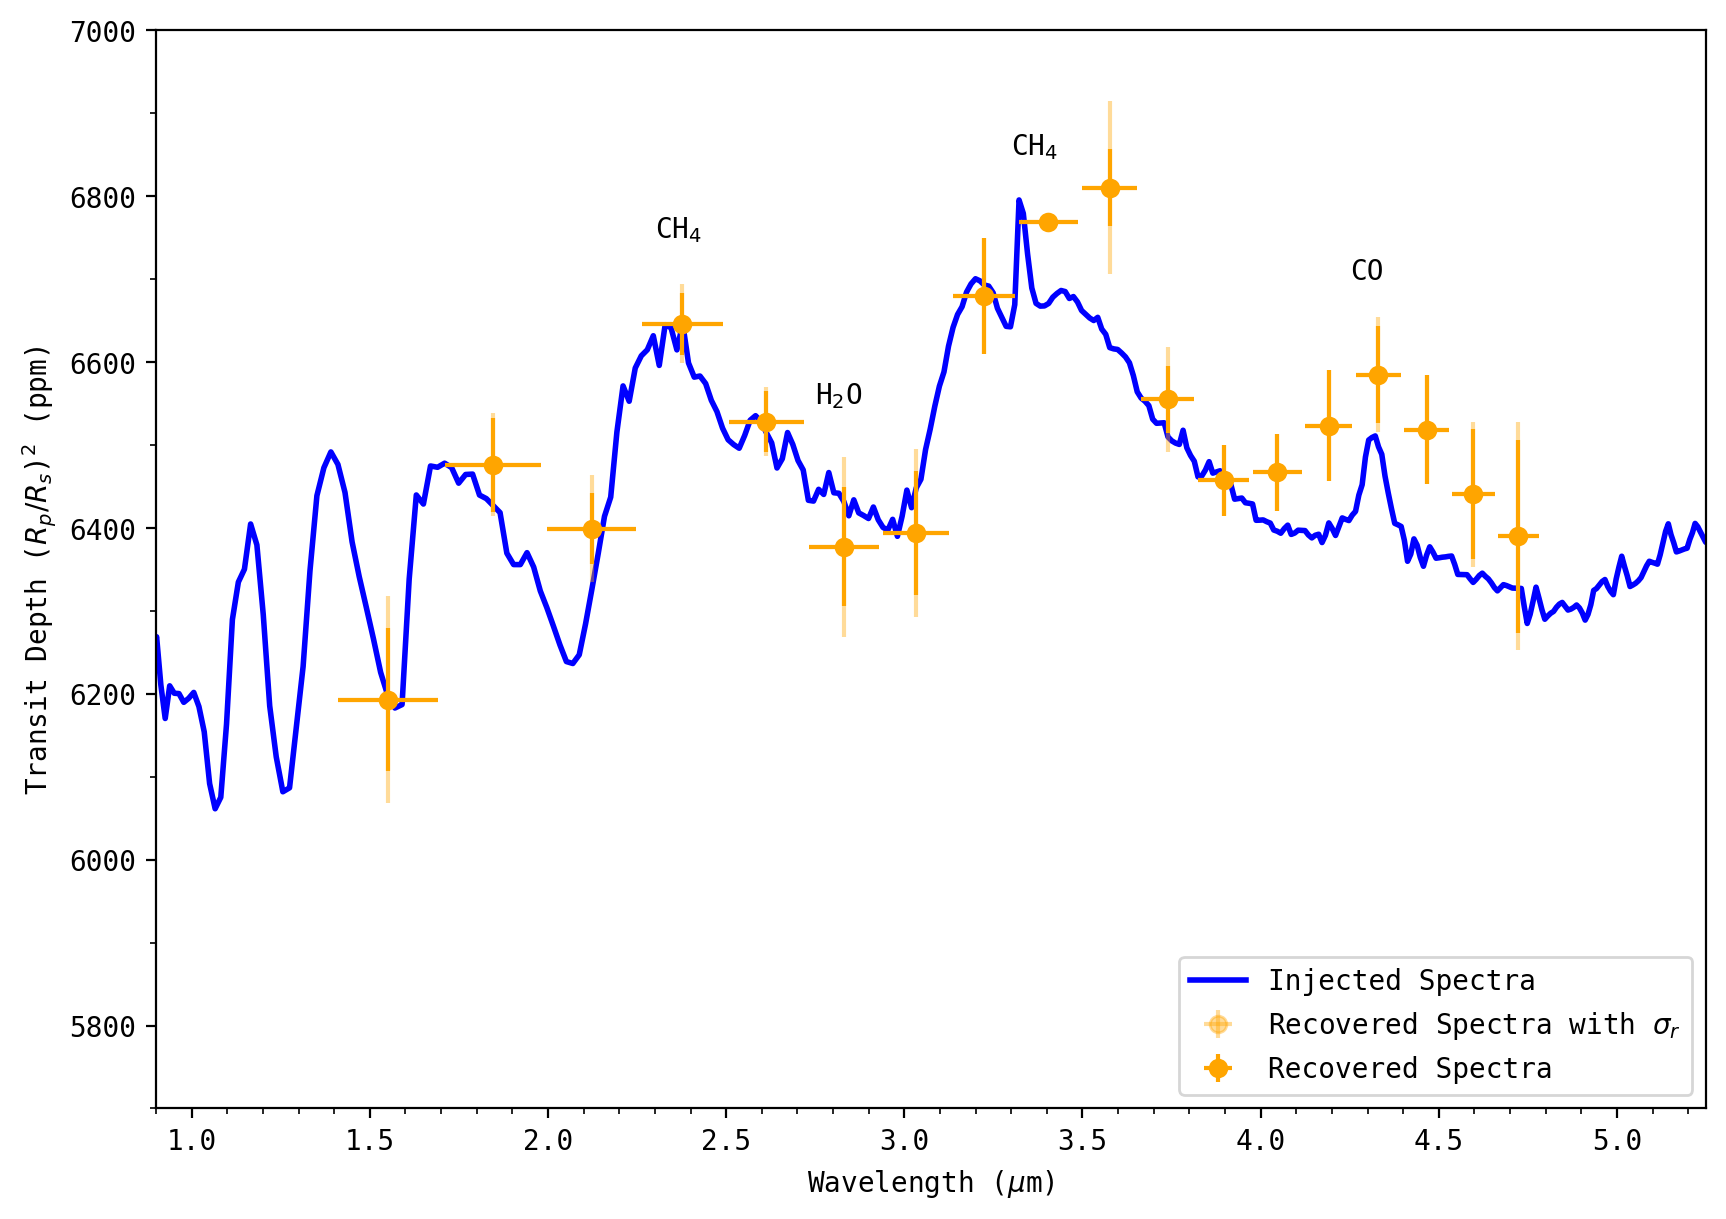

<Figure size 2000x1400 with 0 Axes>

In [22]:
#--------------------------------------------------------------------------
#Load Injected Transmission spectra to compare with recovered value

#Download Injected Spectra
fn_tm  = download_file('https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/transit_spectroscopy_notebook/trans-iso_GJ-0436_0669.0_+0.0_0.56_0001_0.00_model.NIRSpec_PRISM.txt')
destld = shutil.move(fn_tm,save_directory+'trans-iso_GJ-0436_0669.0_+0.0_0.56_0001_0.00_model.NIRSpec_PRISM.txt')        

f = open(save_directory+'trans-iso_GJ-0436_0669.0_+0.0_0.56_0001_0.00_model.NIRSpec_PRISM.txt', 'r')
data = np.genfromtxt(f, delimiter='   ')
model_ws   = data[:,0]
model_spec = data[:,1]

#Read fit transit depths
data = ascii.read(save_directory+'JWST_NIRSpec_Prism_fit_transmission_spectra.csv', format='csv')
wsd  = data['Wavelength Center (um)']
werr = data['Wavelength half-width (um)']
rprs = data['Rp/Rs']
rerr = data['Rp/Rs 1-sigma error']
beta = data['Beta Rednoise Inflation factor']

#plot
fig,axs = plt.subplots()
plt.plot(model_ws,model_spec**2*1E6, linewidth=2,zorder=0,color='blue',label='Injected Spectra')  #overplot Transit model at data
plt.errorbar(wsd,rprs**2*1E6,xerr=werr,yerr=2*rerr*rprs*1E6*beta, fmt='o',zorder=5,alpha=0.4,color='orange',label='Recovered Spectra with $\sigma_r$')
plt.errorbar(wsd,rprs**2*1E6,xerr=werr,yerr=2*rerr*rprs*1E6, fmt='o',zorder=10,color='orange',label='Recovered Spectra')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transit Depth ($R_p/R_s$)$^2$ (ppm)')
axs.yaxis.set_major_locator(ticker.MultipleLocator(200))
axs.yaxis.set_minor_locator(ticker.MultipleLocator(100))
axs.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
axs.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
axs.text(3.3,6850,'CH$_4$')
axs.text(4.25,6700,'CO')
axs.text(2.3,6750,'CH$_4$')
axs.text(2.75,6550,'H$_2$O')
plt.ylim(5700,7000)
plt.xlim(0.9,5.25)
plt.legend(loc='lower right')    
plt.show()
plt.clf()


By and large, the injected transit depths are well recovered across the spectra, with features such as H$_2$O and CH$_4$ easily detected. There is a bit of an offset in data-points long-ward of 3.5 $\mu$m that could perhaps be due to changes in CO$_2$ or H$_2$O absorption features from ice built up on the cryogenic window during the CV3 test. These wavelengths show some increases in time correlated noise ($\sigma_r$), which has been measured here, and the errors in the plot also show the transit depths with this error included. 

The precisions from the ground-based test are very encouraging, with the best measured bin (which occurs in a clean part of the spectrum with high count rates) achieving near-photon limited transit depths measured to about 30 ppm in only 2 hours of data, and with minimal time correlated noise ($\sigma_r$).

For more robust error estimates, in practice the least-squares minimization performed here would be replaced by an MCMC routine.  In addition, with actual transit data, the transit fit parameters (e.g. $i$, $a/R_{star}$, T$_0$) would also have to be first fit as well, as they can/will differ from literature estimates in high precision transit light curves as JWST will provide.
